# This Jupyter Notebook is to reproduce the tables provided in SOBR report. The input files are from output folder of original 
# SOBR 

In [18]:
import SOBRTablefig as st
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import matplotlib.colors


In [2]:
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df[['Station', 'Latitude', 'Longitude', 'Trend Direction', 'Trend Significance', 'Slope as % of MAF','Trend SignificancePtt']]

def load_datatime(file_path):
    df = pd.read_csv(file_path)
    df = df[['Station', 'Latitude', 'Longitude', 'Trend Direction', 'Trend Significance', 'slope over CNP','Trend SignificancePtt']]
    df.rename(columns={'slope over CNP': 'Slope as % of MAF'}, inplace=True)
    return df

def plot_data(ax, subset_df, result_df70, result_df80, result_df90, result_df2020, fig_num,indm):
    if fig_num == 0:
        ax.text(0.10, 0.98, indm, ha='center', va='bottom', fontsize=10.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.10, 0.965, "Station", ha='center', va='bottom', fontsize=8.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.30, 0.98, "1971-2000", ha='center', va='bottom', fontsize=10.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.30, 0.965, "MK    Pettitt   Both ", ha='center', va='bottom', fontsize=8.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.50, 0.98, "1981-2010", ha='center', va='bottom', fontsize=10.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.50, 0.965, "MK    Pettitt   Both", ha='center', va='bottom', fontsize=8.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.70, 0.98, "1991-2020", ha='center', va='bottom', fontsize=10.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.70, 0.965, "MK    Pettitt   Both ", ha='center', va='bottom', fontsize=8.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.90, 0.98, "1971-2020", ha='center', va='bottom', fontsize=10.5, color='black', weight='bold', transform=ax.transAxes)
        ax.text(0.90, 0.965, "MK    Pettitt   Both", ha='center', va='bottom', fontsize=8.5, color='black', weight='bold', transform=ax.transAxes)

    ax.scatter(subset_df['Long'], subset_df['Lat'], label='Station', marker='')

    st.annotate_stations(ax, subset_df)

    st.scatter_trend_information(ax, subset_df, result_df70, 1.2)
    st.scatter_trend_information(ax, subset_df, result_df80, 1.42)
    st.scatter_trend_information(ax, subset_df, result_df90, 1.63)
    st.scatter_trend_information(ax, subset_df, result_df2020, 1.85)
    
    st.scatter_trend_significance(ax, subset_df, result_df70, 1.32)
    st.scatter_trend_significance(ax, subset_df, result_df80, 1.54)
    st.scatter_trend_significance(ax, subset_df, result_df90, 1.75)
    st.scatter_trend_significance(ax, subset_df, result_df2020, 1.97)
    
     # Annotate with 'R' if regulated

#     for index, row in subset_df.iterrows():
#         if row['Regulated']:
#             ax.text(row['Long']+0.08, row['Lat']-0.12, '   - R', fontsize=10, color='black', ha='center', va='center', fontweight='normal')
    
#     for index, row in subset_df.iterrows():
#         if row['RHBN']:
#             ax.text(row['Long']+0.08, row['Lat']-0.12, '        N', fontsize=10, color='black', ha='center', va='center', fontweight='normal')

    for index, row in subset_df.iterrows():
        label = ""
        if row['Regulated'] and row['RHBN']:
            label = '  -RN'
        elif row['Regulated']:
            label = '  -R'
        elif row['RHBN']:
            label = '  -N'

        if label:  # Only add text if there's a label to add
            ax.text(row['Long'] + 0.08, row['Lat'] - 0.12, label, fontsize=10, color='black', ha='center', va='center', fontweight='normal')

    
    # Add vertical lines
    for x_position in [1.1,1.32, 1.54, 1.75]:
        ax.axvline(x=x_position + 0.05, color='grey', linestyle='--', linewidth=0.25)
        
        
def count_perc(result_dfs):
    
    # Assuming result_df70, result_df80, result_df90, result_df2020 are your DataFrames
    df_names = ['CNP70', 'CNP80', 'CNP90', 'POR2020']

    # Define a function to calculate count and percentage
    def calculate_count_and_percentage(df, direction, significance):
        if significance == "Unlikely":
            count = df[df['Trend Significance'] == significance].shape[0]
        else:
            count = df[(df['Trend Direction'] == direction) & (df['Trend Significance'] == significance)].shape[0]
        percentage = (count / len(df)) * 100
        return count, percentage

    # Prepare a list to store the results
    results = []

    # Calculate count and percentage for each category in each DataFrame
    categories = ['Highly Likely', 'Very Likely', 'Likely']
    directions = ['Increasing', 'Decreasing']
    for category in categories:
        for direction in directions:
            row = [f'{category} ({direction})']
            for df in result_dfs:
                count, percentage = calculate_count_and_percentage(df, direction, category)
                row.extend([count, percentage])
            results.append(row)

    # Add "Unlikely" without direction
    row = ['Unlikely']
    for df in result_dfs:
        count, percentage = calculate_count_and_percentage(df, None, 'Unlikely')
        row.extend([count, percentage])
    results.append(row)

    # Define the MultiIndex for the columns
    columns = pd.MultiIndex.from_product([df_names, ['Count', 'Percentage']], names=['', 'Significance and Trend Direction'])

    # Define the index for the rows
    index = [f'{category} ({direction})' for category in categories for direction in directions] + ['Unlikely']

    # Ensure the number of columns matches the length of each row in results
    assert all(len(row) == len(columns) + 1 for row in results), "Mismatch between data columns and headers"

    # Convert the results into a DataFrame
    results_count = pd.DataFrame([row[1:] for row in results], index=index, columns=columns)

    return(results_count)


        
        


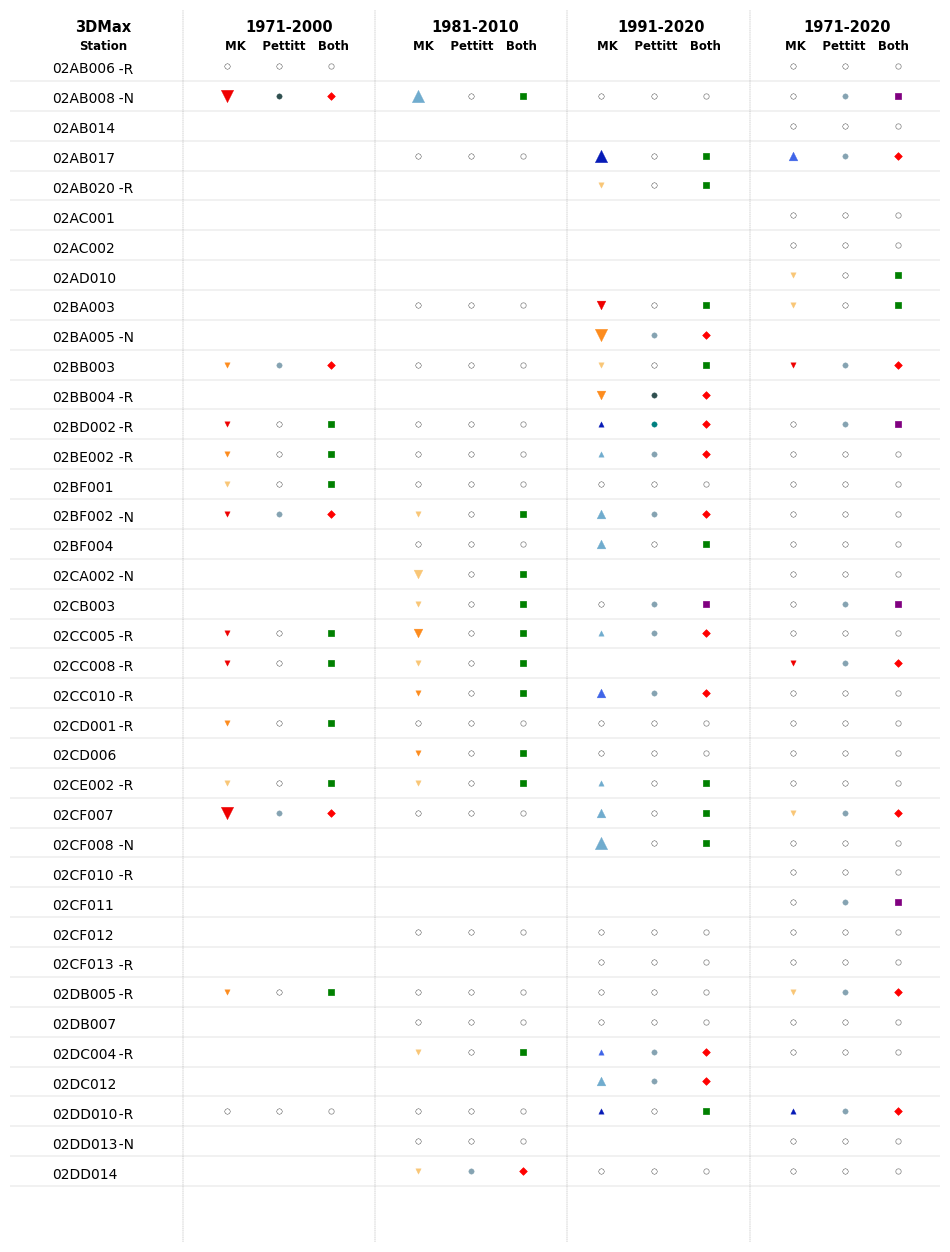

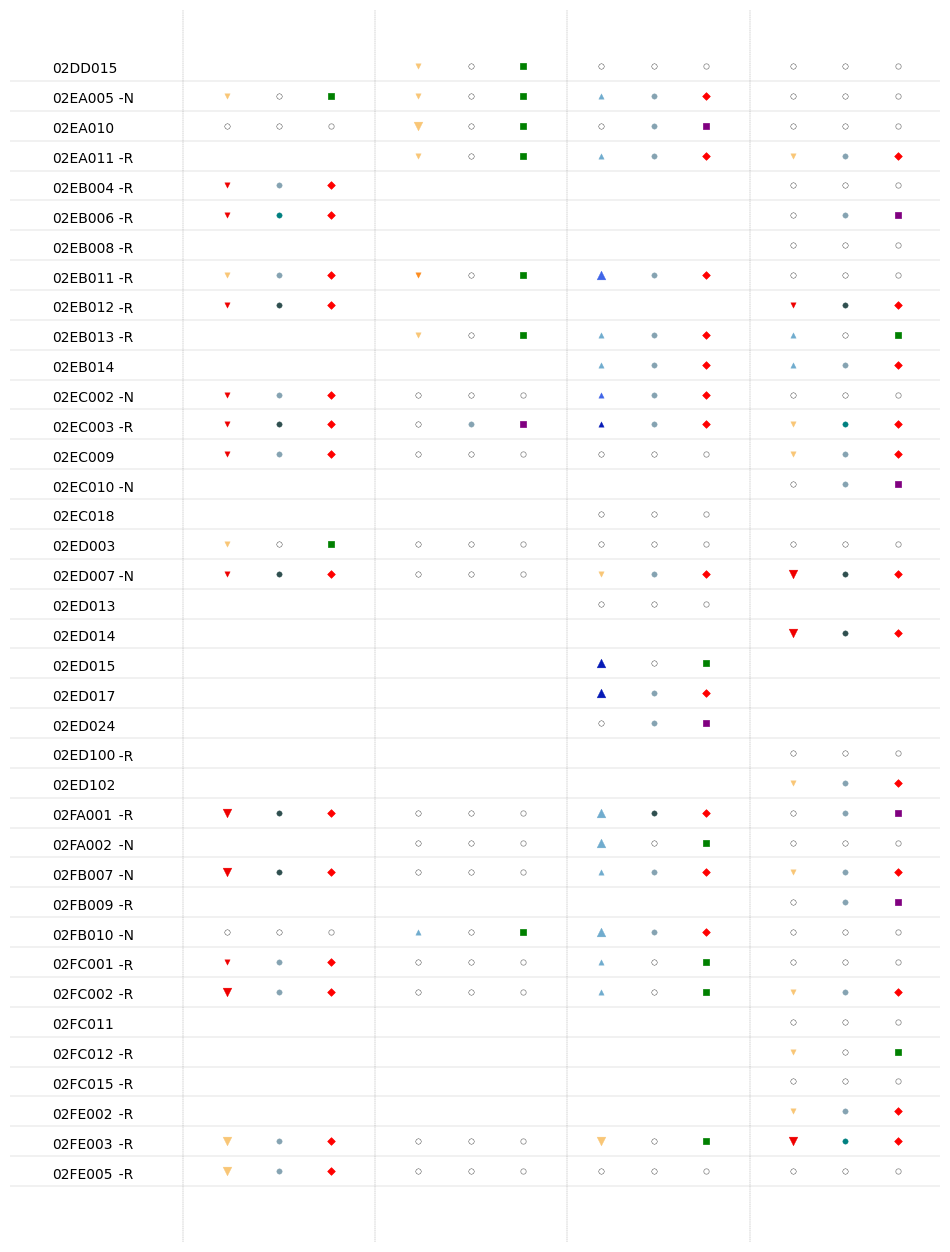

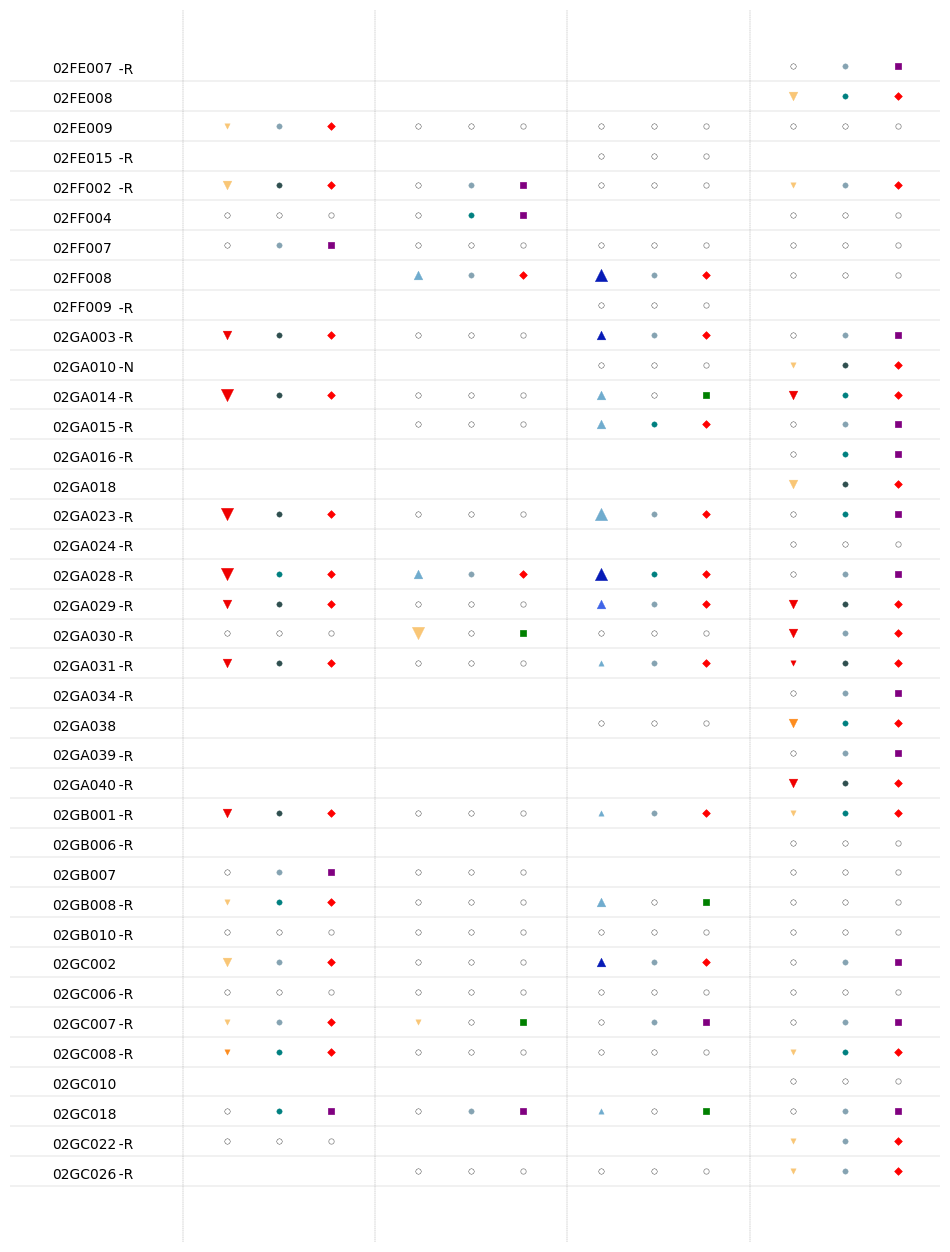

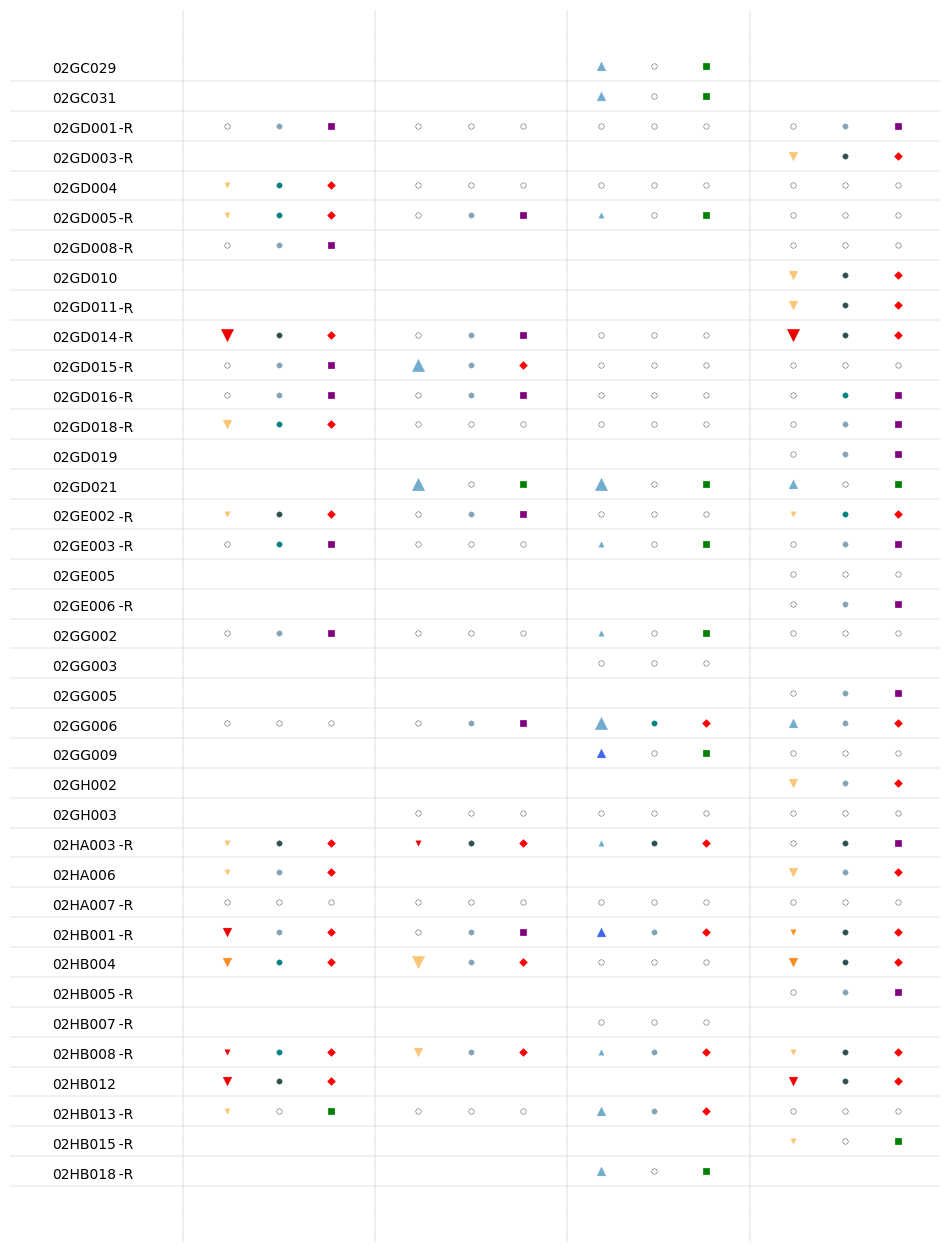

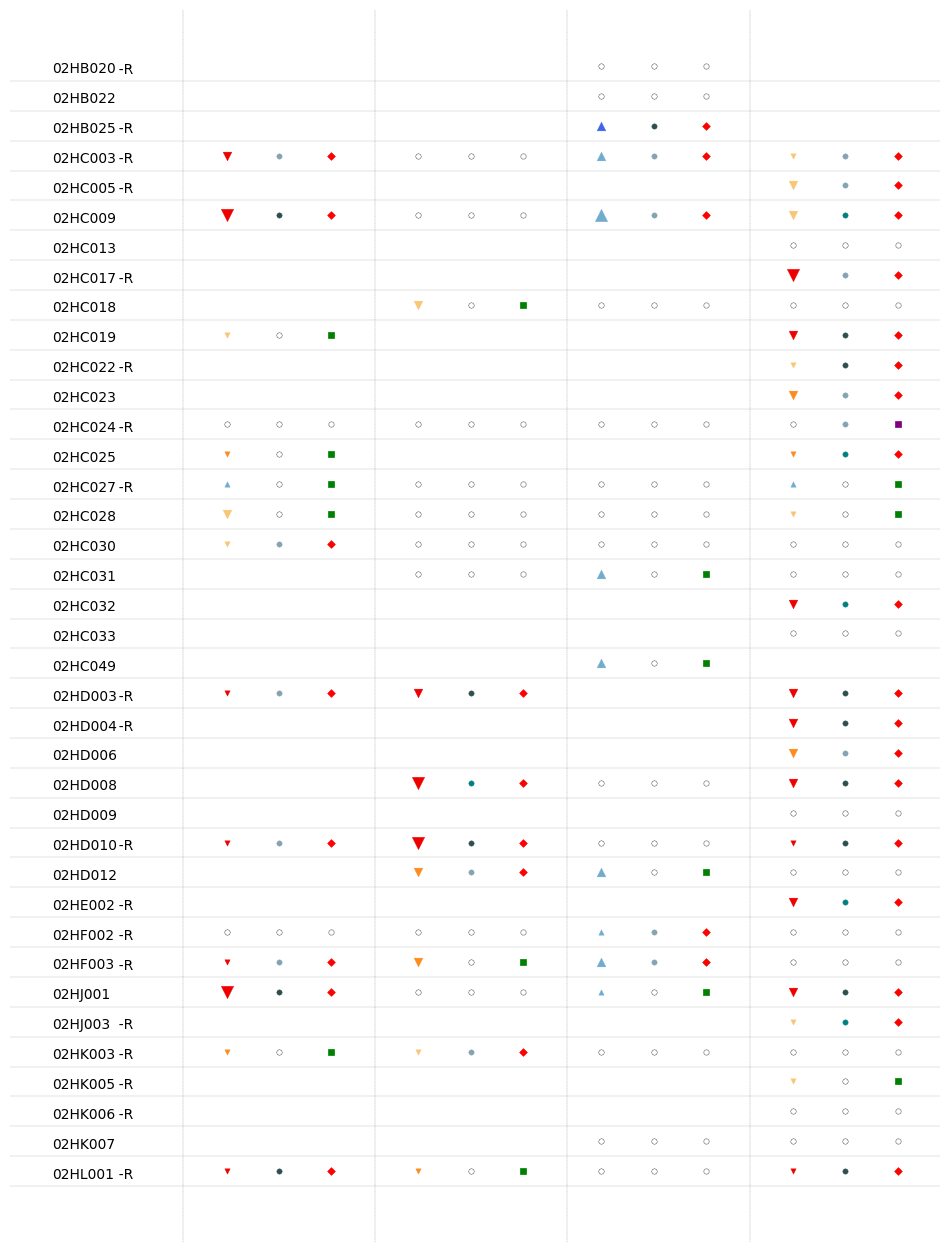

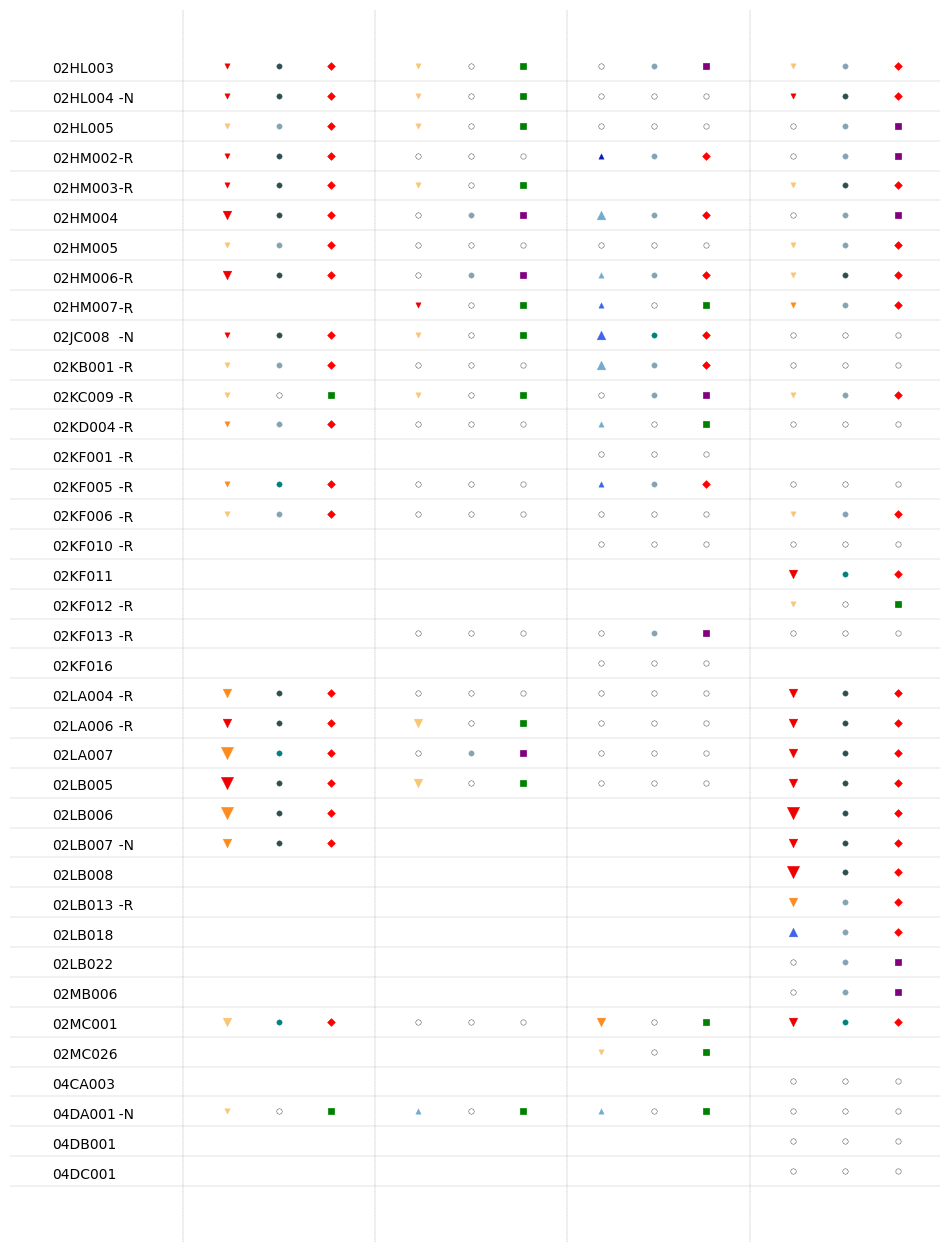

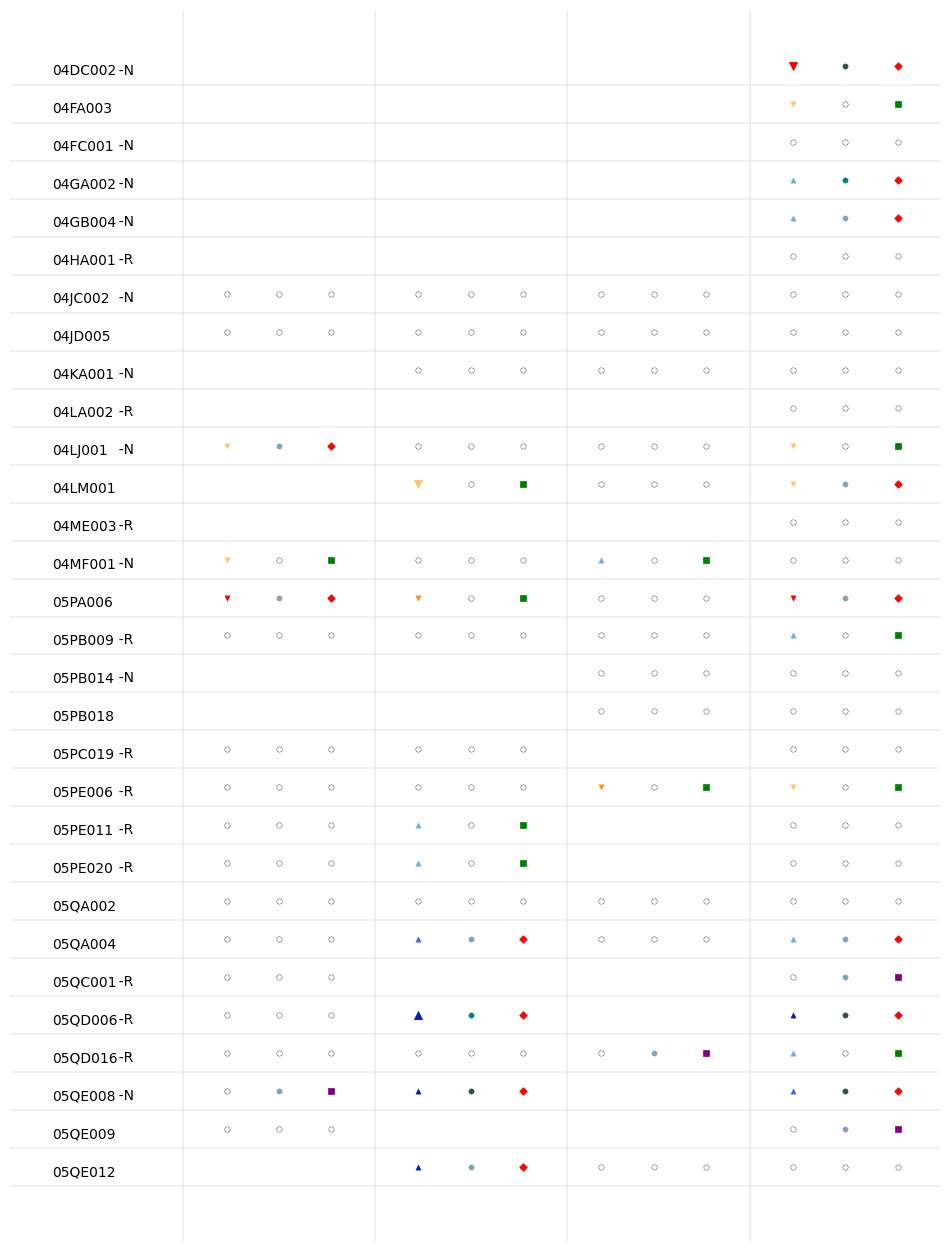

Loaded and trimmed image 'figure_1.png' as 'figure_1'
Loaded and trimmed image 'figure_2.png' as 'figure_2'
Loaded and trimmed image 'figure_3.png' as 'figure_3'
Loaded and trimmed image 'figure_4.png' as 'figure_4'
Loaded and trimmed image 'figure_5.png' as 'figure_5'
Loaded and trimmed image 'figure_6.png' as 'figure_6'
Loaded and trimmed image 'figure_7.png' as 'figure_7'


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\TIWARIDI\\OneDrive - Government of Ontario\\Documents\\WSCdata\\SOBR_FinalStations\\ResultTable\\Combined\\3DMF.png'

In [3]:
file_paths = [
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2000\allSOBRplot\MKnP_3daymaxflow.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1980_2010\allSOBRplot\MKnP_3daymaxflow.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1990_2020\allSOBRplot\MKnP_3daymaxflow.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2020\allSOBRplot\MKnP_3daymaxflow.csv"
]

result_dfs = [load_data(file_path) for file_path in file_paths]
result_df70, result_df80, result_df90, result_df2020 = result_dfs

sobr_file_path = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\SOBRstations1rNnew.csv'
sobr_df = pd.read_csv(sobr_file_path)

stations_per_figure = 38
num_figures = -(-len(sobr_df) // stations_per_figure)
indm="3DMax"
for fig_num in range(num_figures):
    start_idx = fig_num * stations_per_figure
    end_idx = min((fig_num + 1) * stations_per_figure, len(sobr_df))
    subset_df = sobr_df.iloc[start_idx:end_idx]
    fig, ax = plt.subplots(figsize=(12, 16))

    plot_data(ax, subset_df, result_df70, result_df80, result_df90, result_df2020, fig_num,indm)

    ax.axis('off')
    save_directory = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\3DMF'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, f'figure_{fig_num + 1}.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    
# Concatenating Images
folder_path = save_directory 
concatenated_image = st.concat_images(folder_path)

# concatenated_image.show()
save_path =  r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Combined\3DMF.png"
concatenated_image.save(save_path)    
    
    
#count percentage and toatl station number for each category
results_count=count_perc(result_dfs)
# Save the results to a CSV file
file_name = 'trend_analysis_results_table.csv'
# Save the DataFrame to a CSV file
results_count.to_csv(os.path.join(save_directory, file_name))


## 3 Day Max flow Time

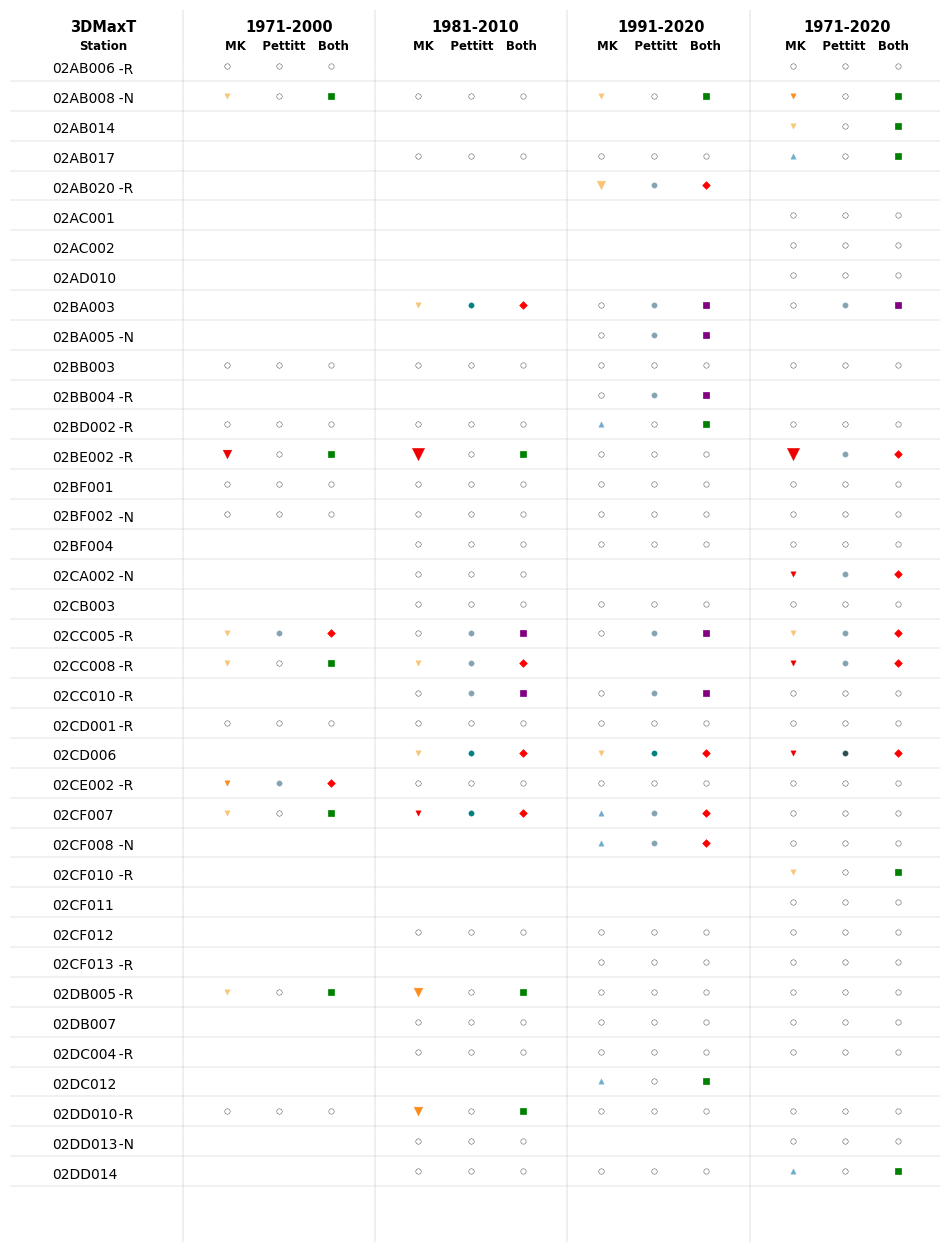

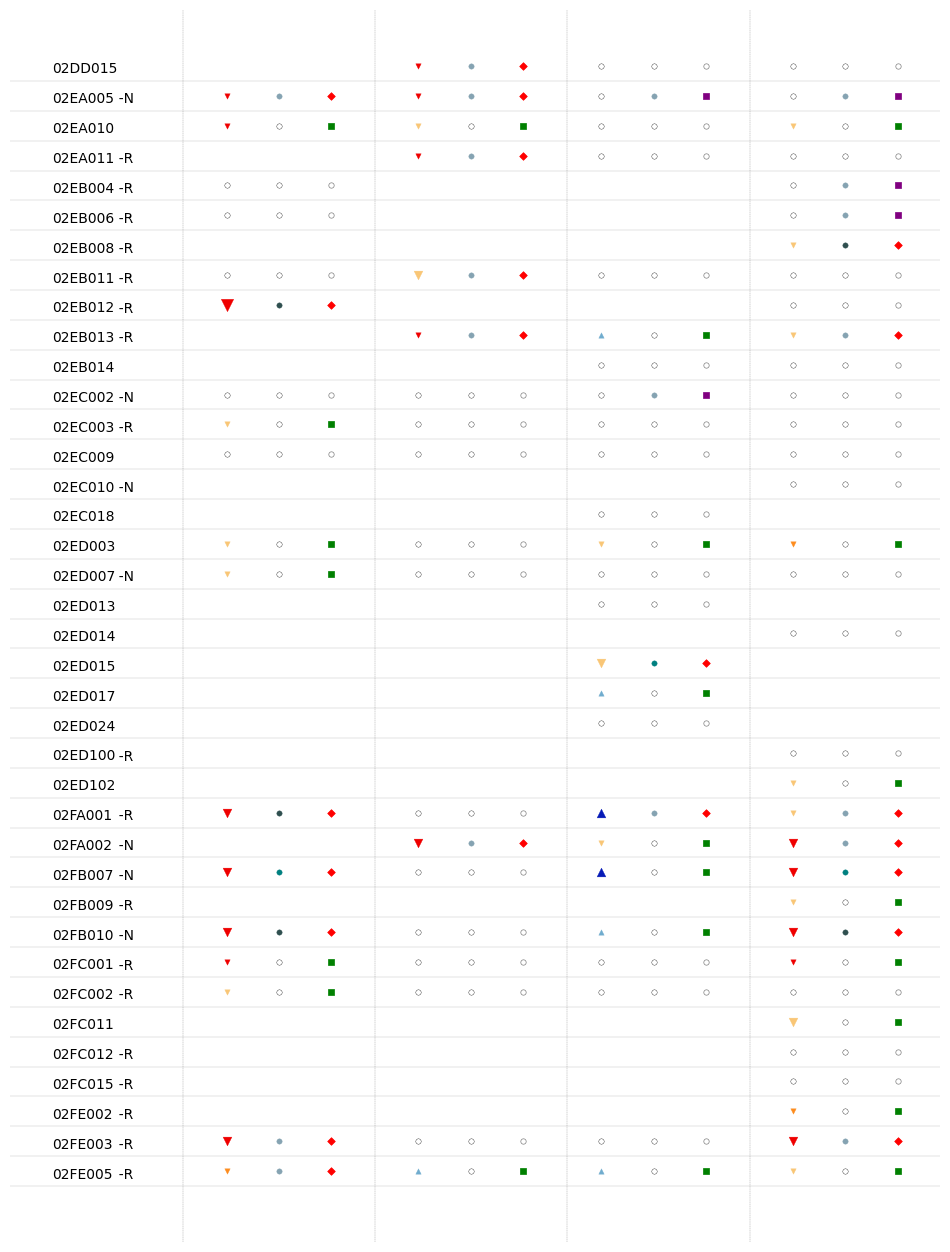

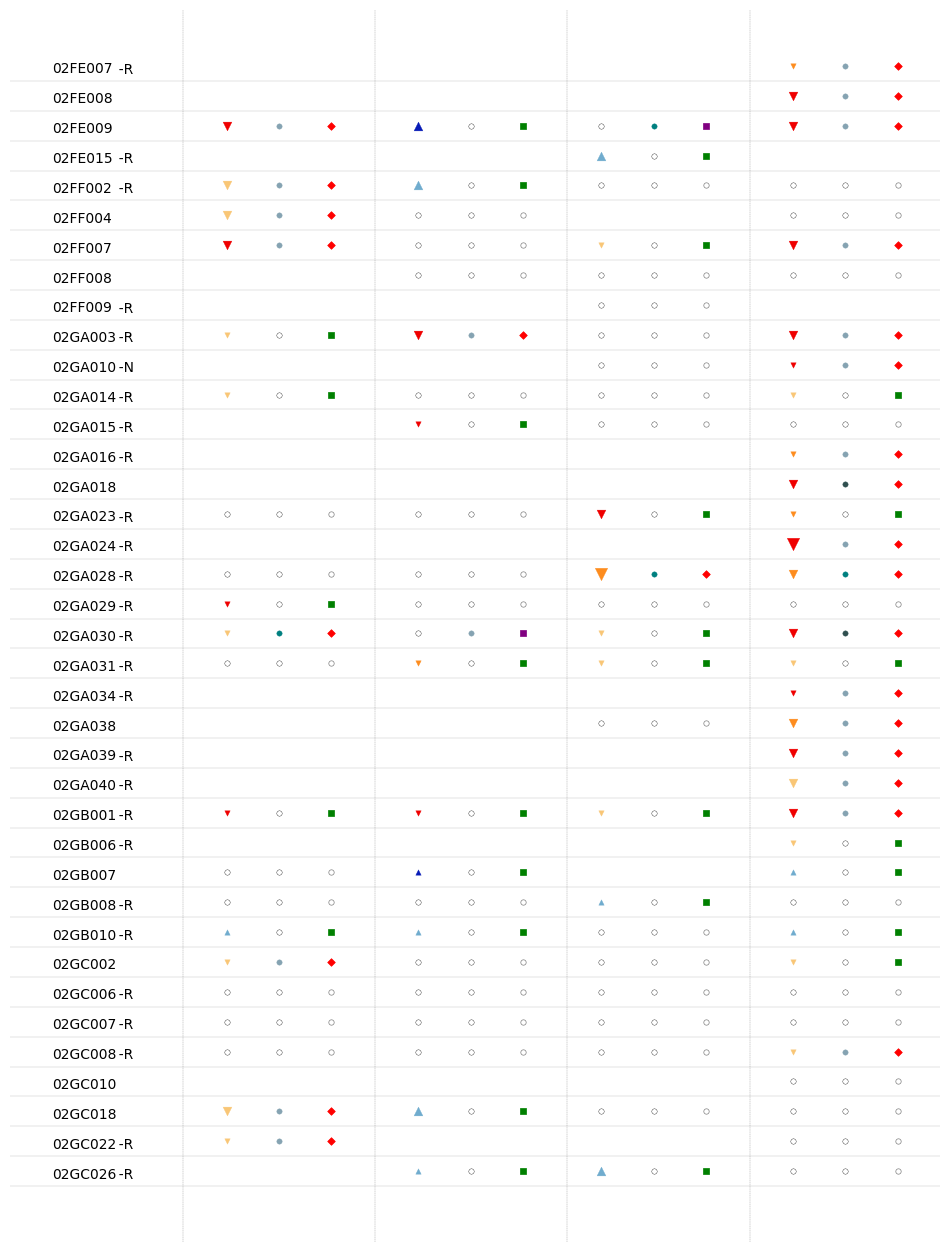

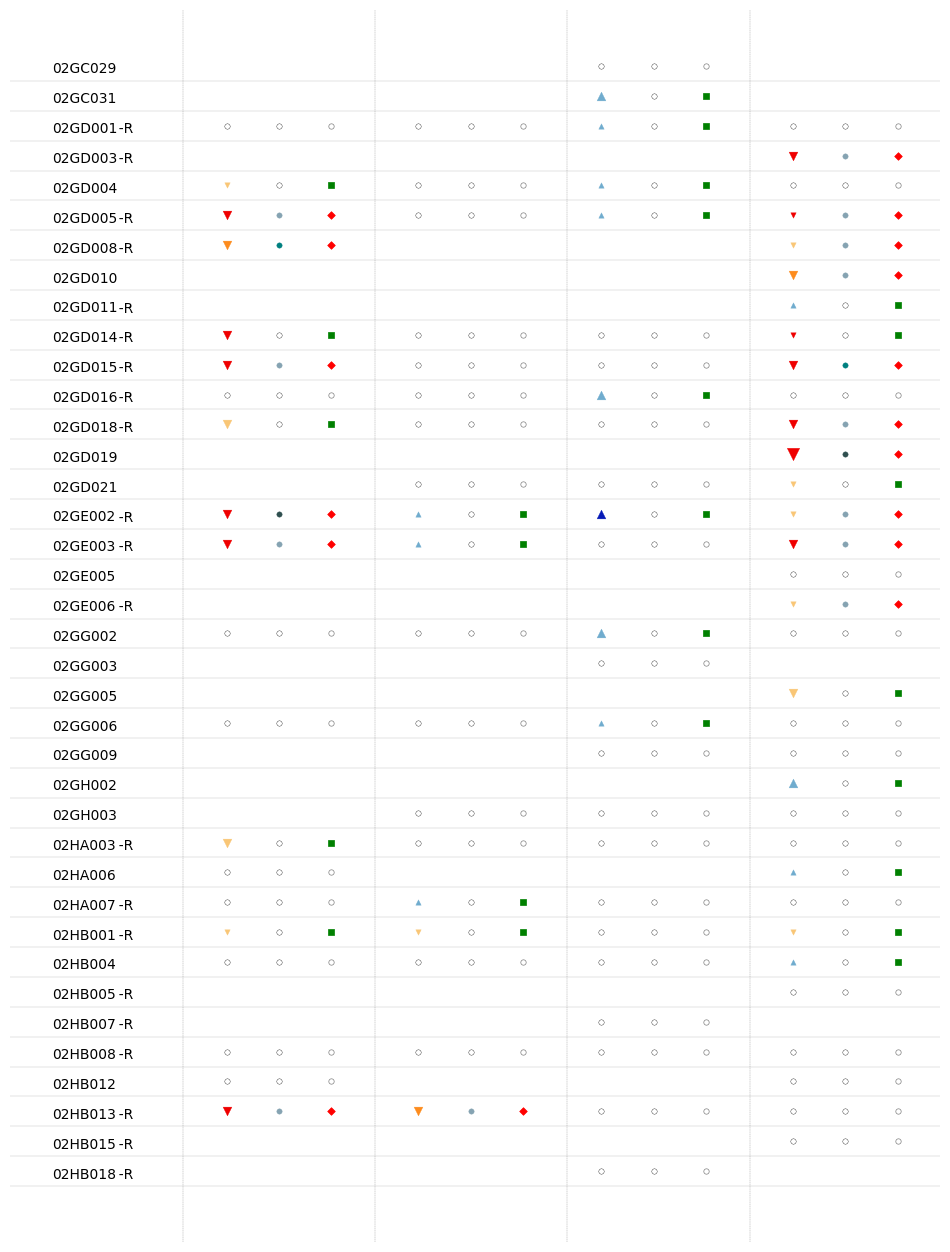

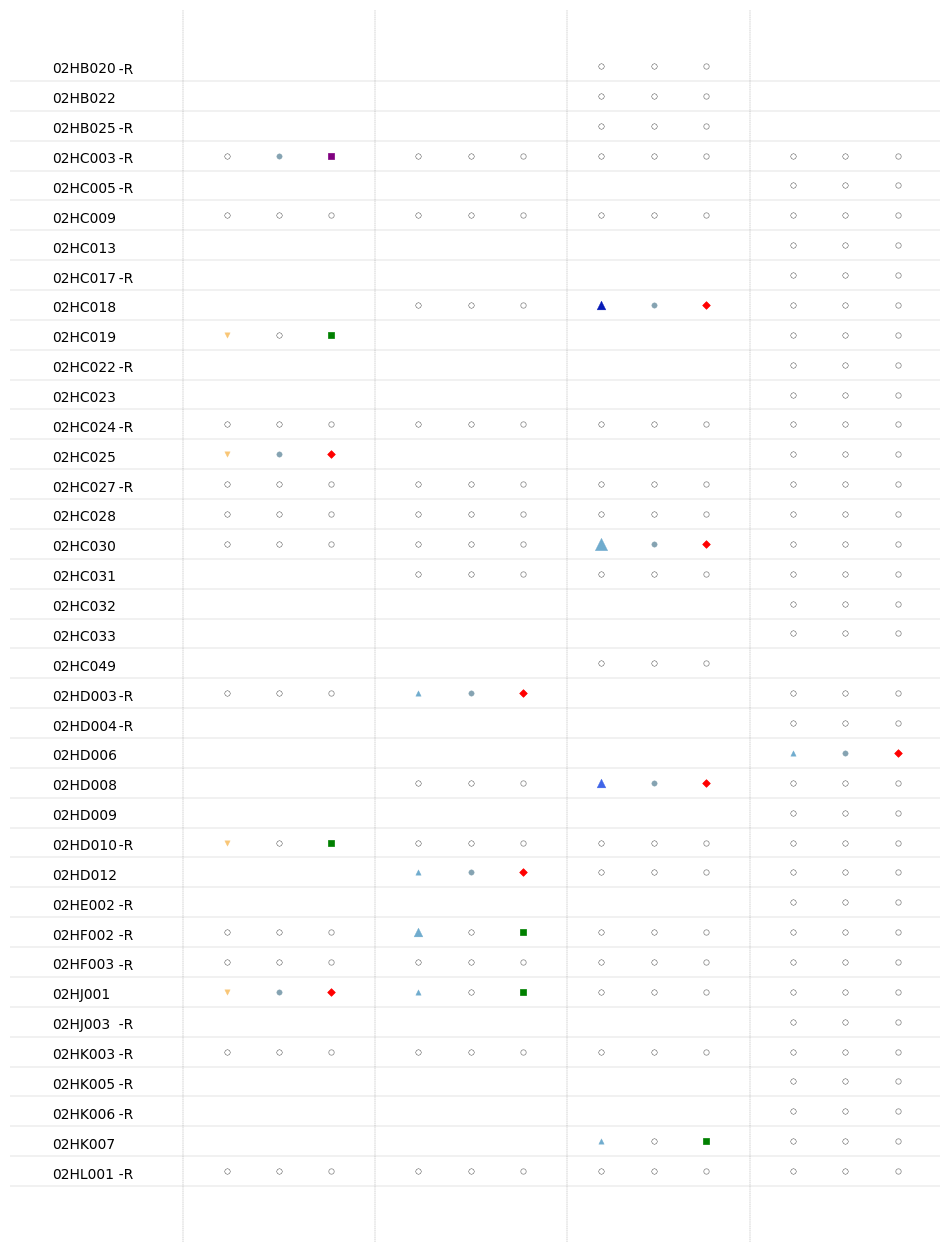

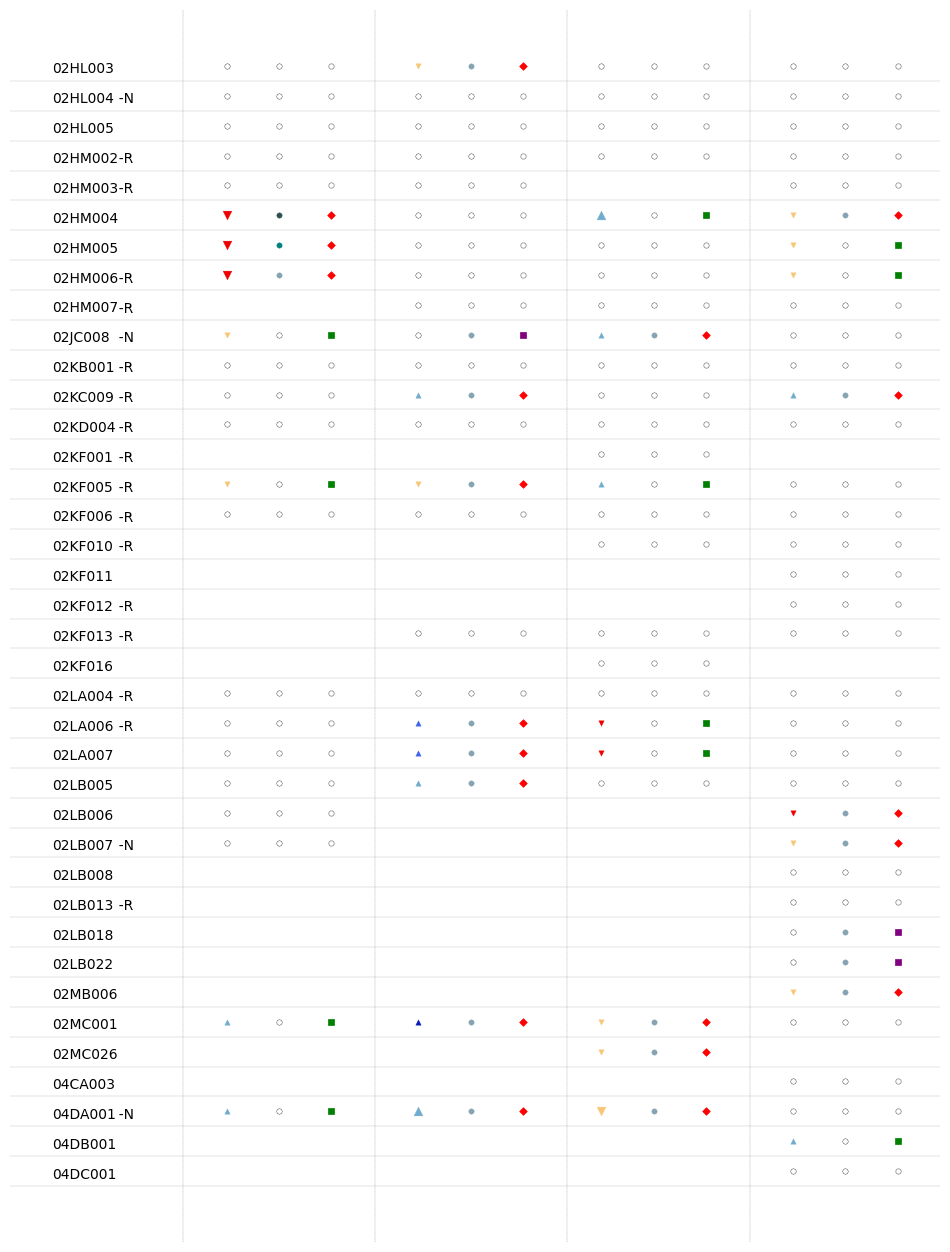

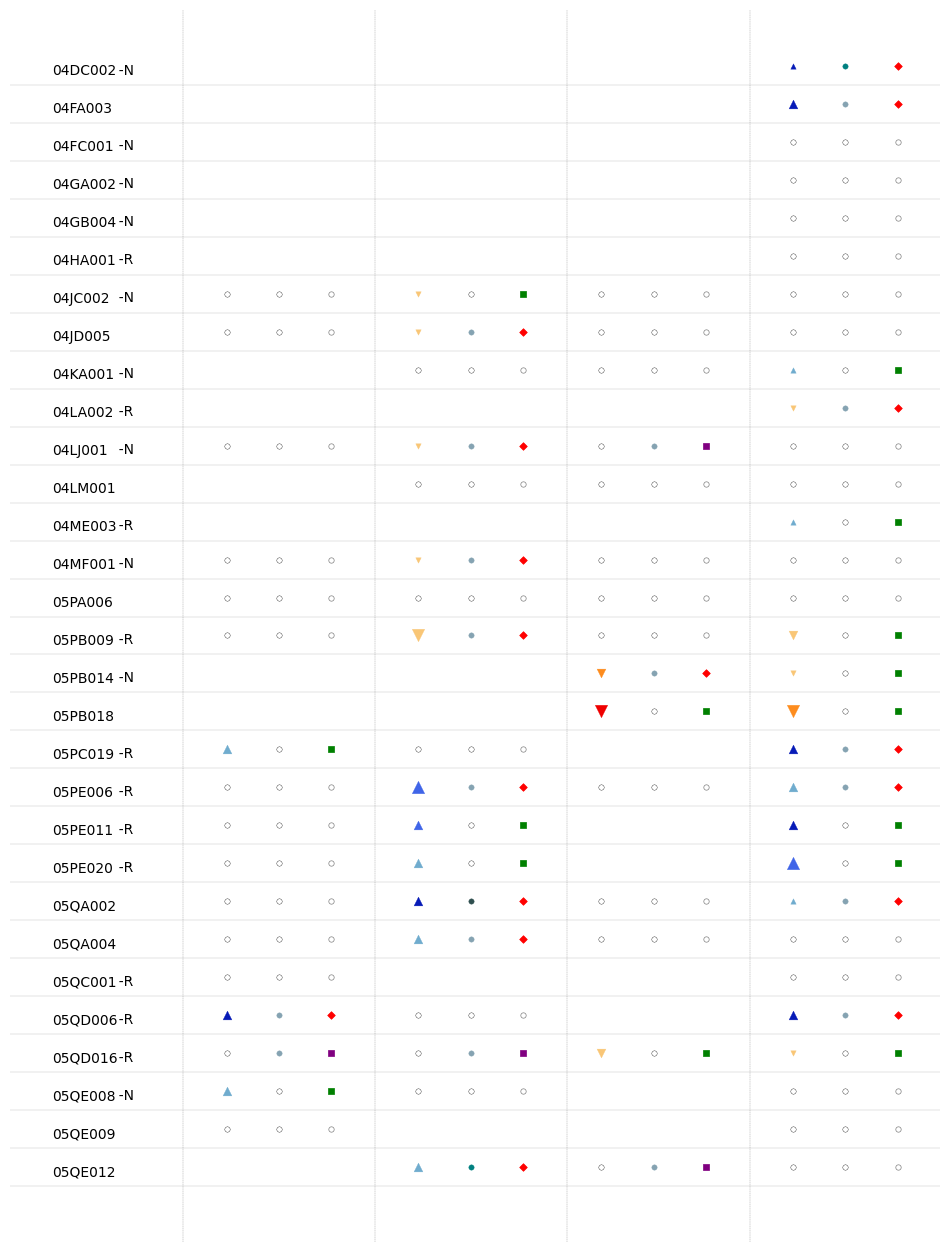

Loaded and trimmed image 'figure_1.png' as 'figure_1'
Loaded and trimmed image 'figure_2.png' as 'figure_2'
Loaded and trimmed image 'figure_3.png' as 'figure_3'
Loaded and trimmed image 'figure_4.png' as 'figure_4'
Loaded and trimmed image 'figure_5.png' as 'figure_5'
Loaded and trimmed image 'figure_6.png' as 'figure_6'
Loaded and trimmed image 'figure_7.png' as 'figure_7'


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\TIWARIDI\\OneDrive - Government of Ontario\\Documents\\WSCdata\\SOBR_FinalStations\\ResultTable\\Combined\\3DMFT.png'

In [4]:

file_paths = [
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2000\allSOBRplot\MKnP_3daymaxflowTime.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1980_2010\allSOBRplot\MKnP_3daymaxflowTime.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1990_2020\allSOBRplot\MKnP_3daymaxflowTime.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2020\allSOBRplot\MKnP_3daymaxflowTime.csv"
]

result_dfs = [load_datatime(file_path) for file_path in file_paths]
result_df70, result_df80, result_df90, result_df2020 = result_dfs


# Assuming sobr_df and result_df70, result_df80, result_df90, result_df2020 are defined and populated DataFrames
stations_per_figure = 38
num_figures = -(-len(sobr_df) // stations_per_figure)
indm="3DMaxT"
for fig_num in range(num_figures):
    start_idx = fig_num * stations_per_figure
    end_idx = min((fig_num + 1) * stations_per_figure, len(sobr_df))
    subset_df = sobr_df.iloc[start_idx:end_idx]
    fig, ax = plt.subplots(figsize=(12, 16))
    
    plot_data(ax, subset_df, result_df70, result_df80, result_df90, result_df2020,fig_num,indm)

    ax.axis('off')
    save_directory = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\3DMFT'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, f'figure_{fig_num + 1}.png')
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
 
    plt.show() 
    
    
# Concatenating Images
folder_path = save_directory 
concatenated_image = st.concat_images(folder_path)

# concatenated_image.show()
save_path =  r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Combined\3DMFT.png"
concatenated_image.save(save_path)


#count percentage and toatl station number for each category
results_count=count_perc(result_dfs)
# Save the results to a CSV file
file_name = 'trend_analysis_results_table.csv'
# Save the DataFrame to a CSV file
results_count.to_csv(os.path.join(save_directory, file_name))


## 7 Day Flow

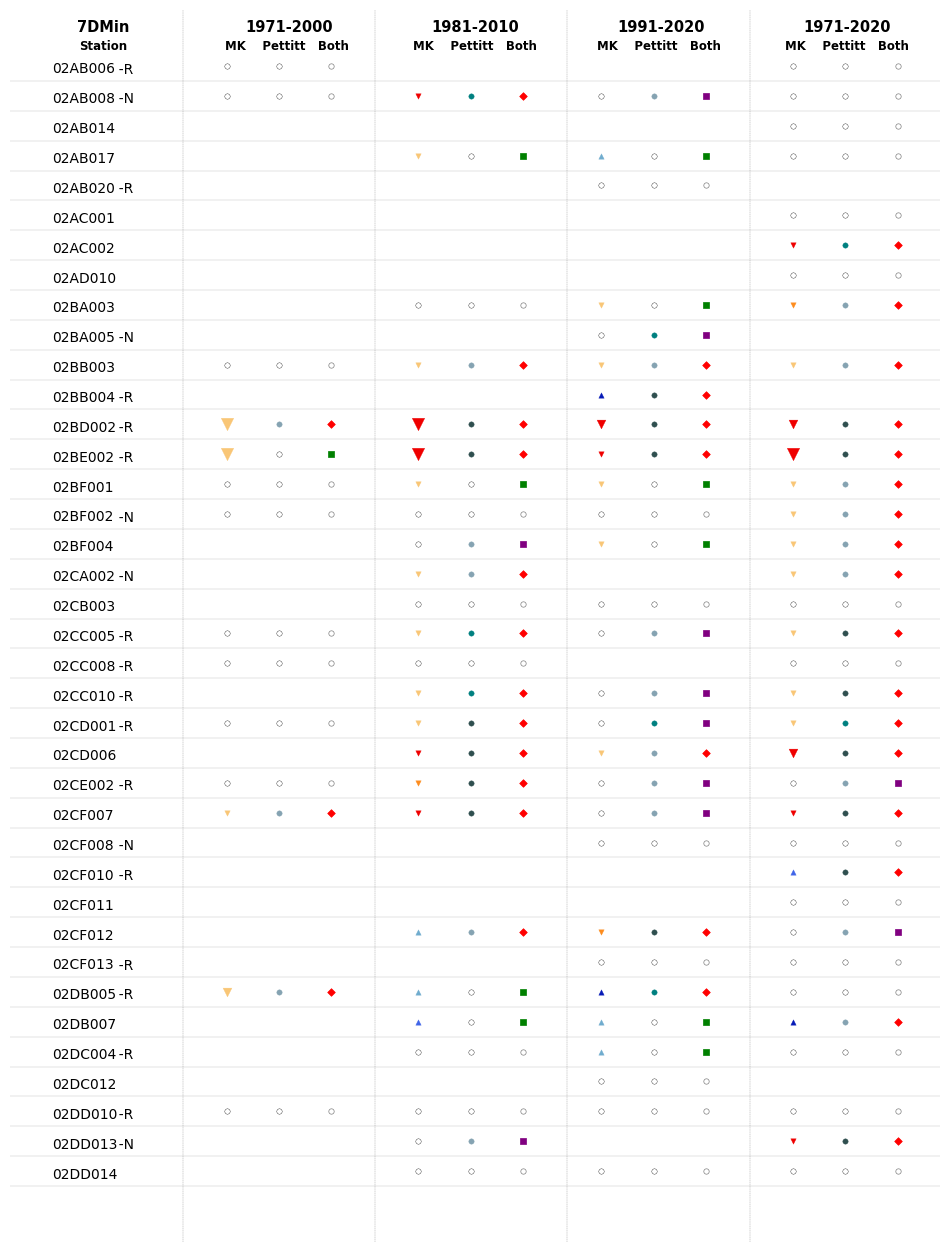

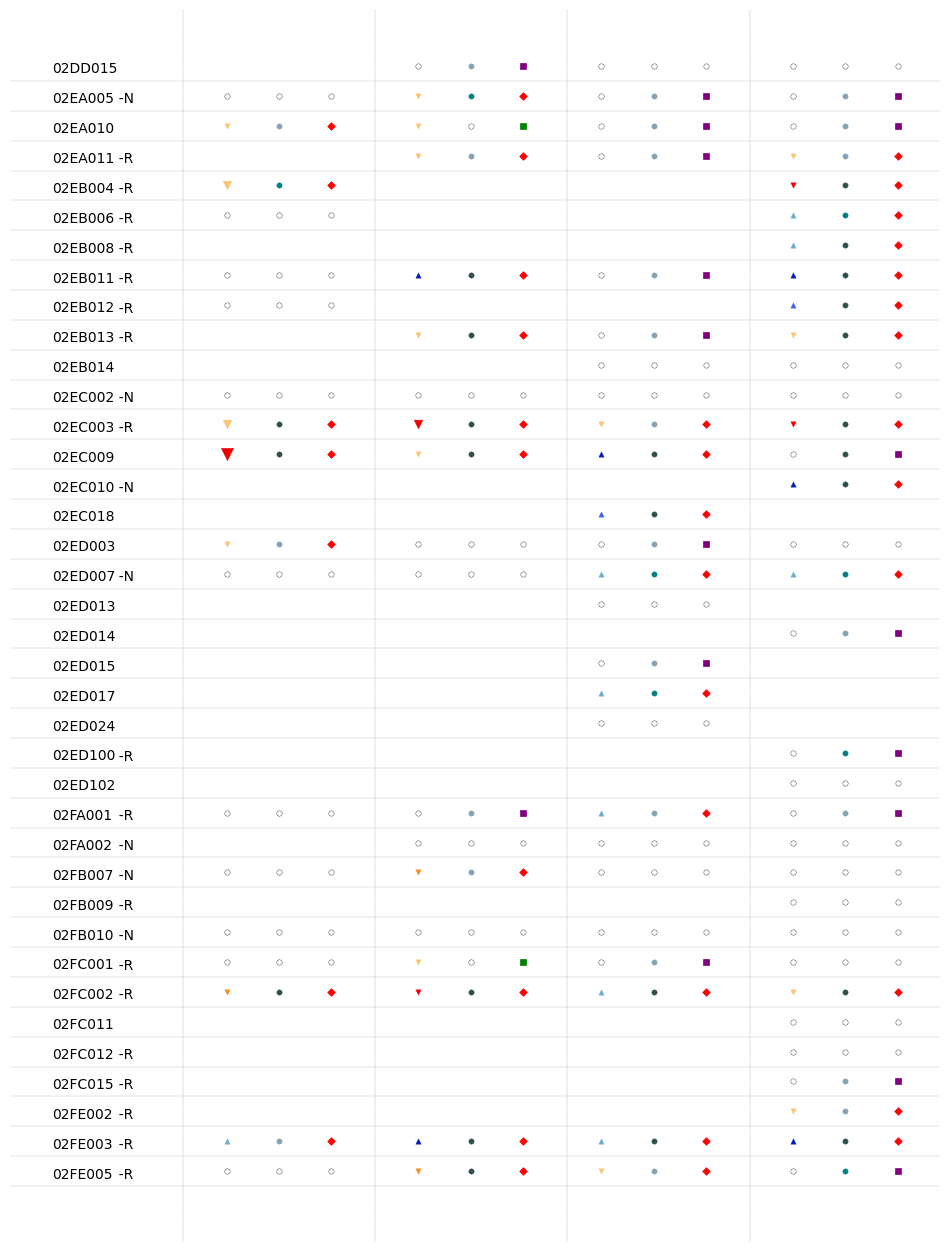

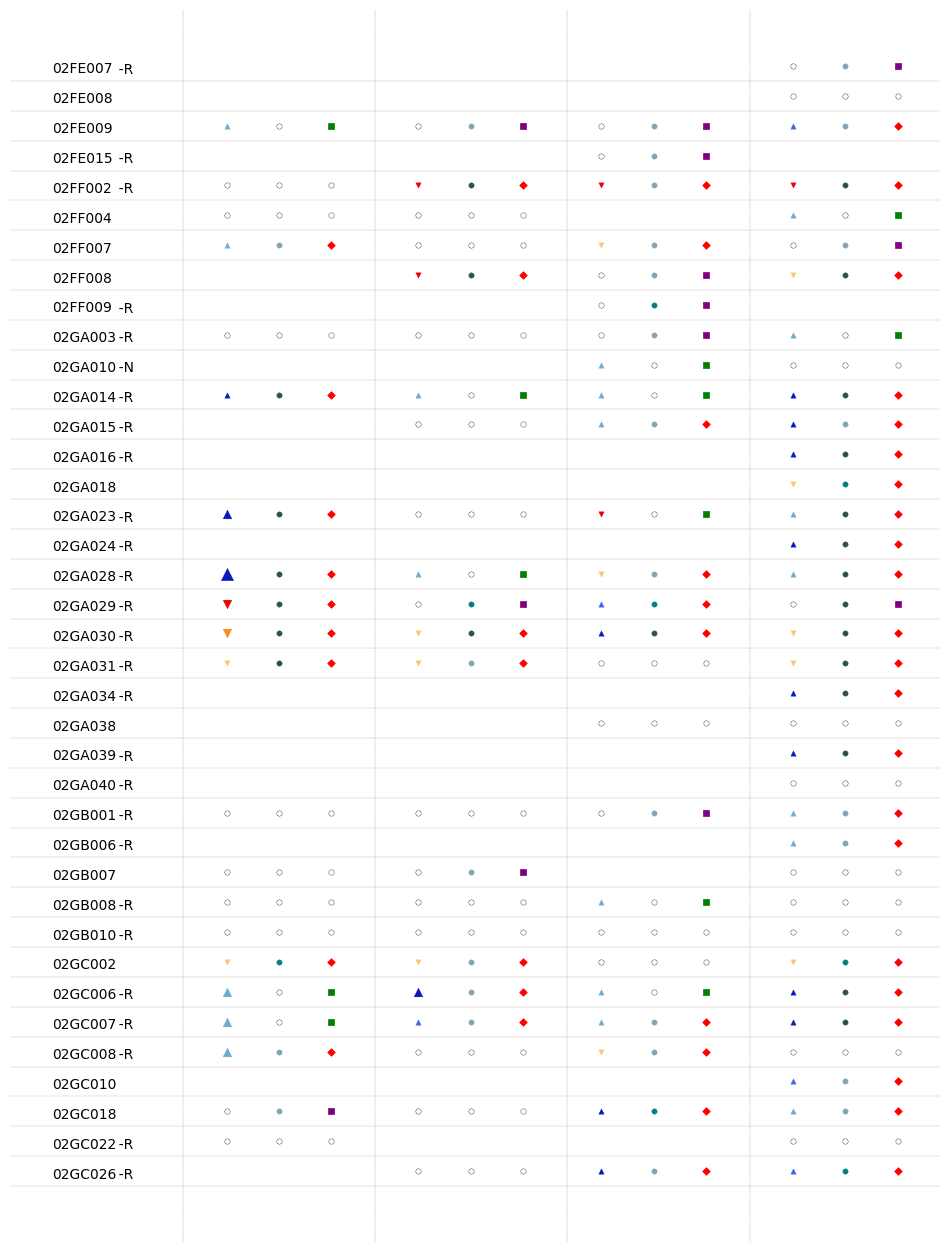

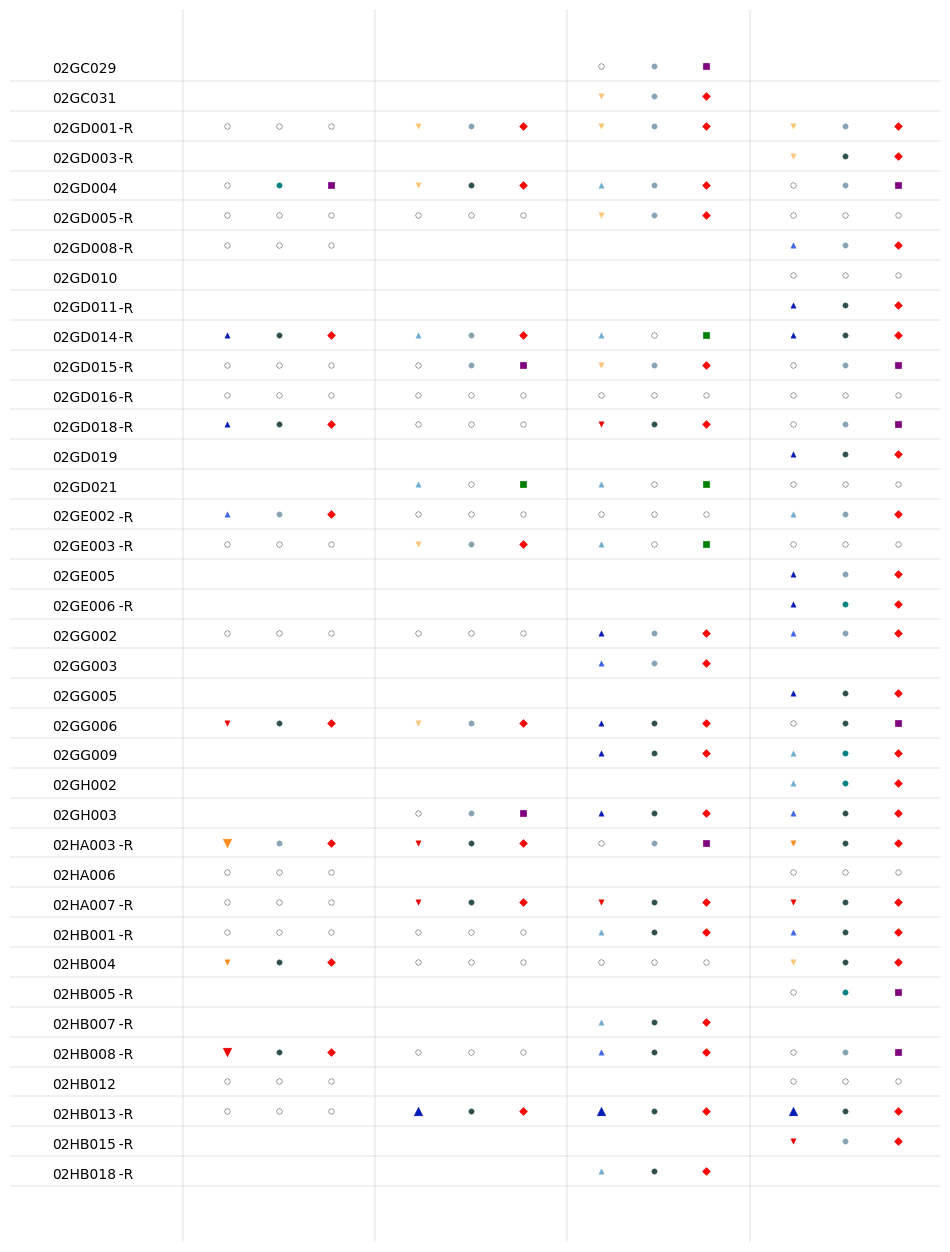

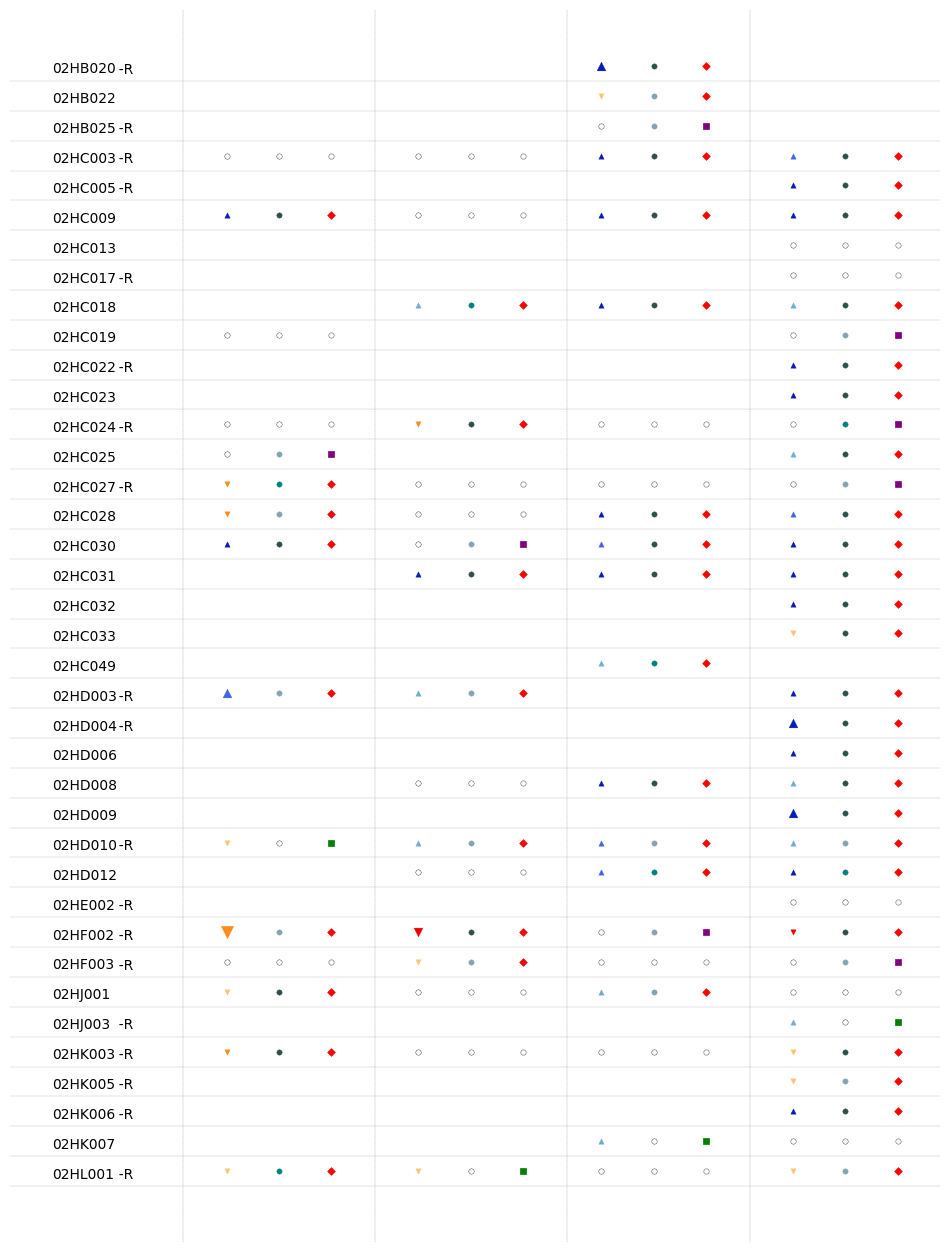

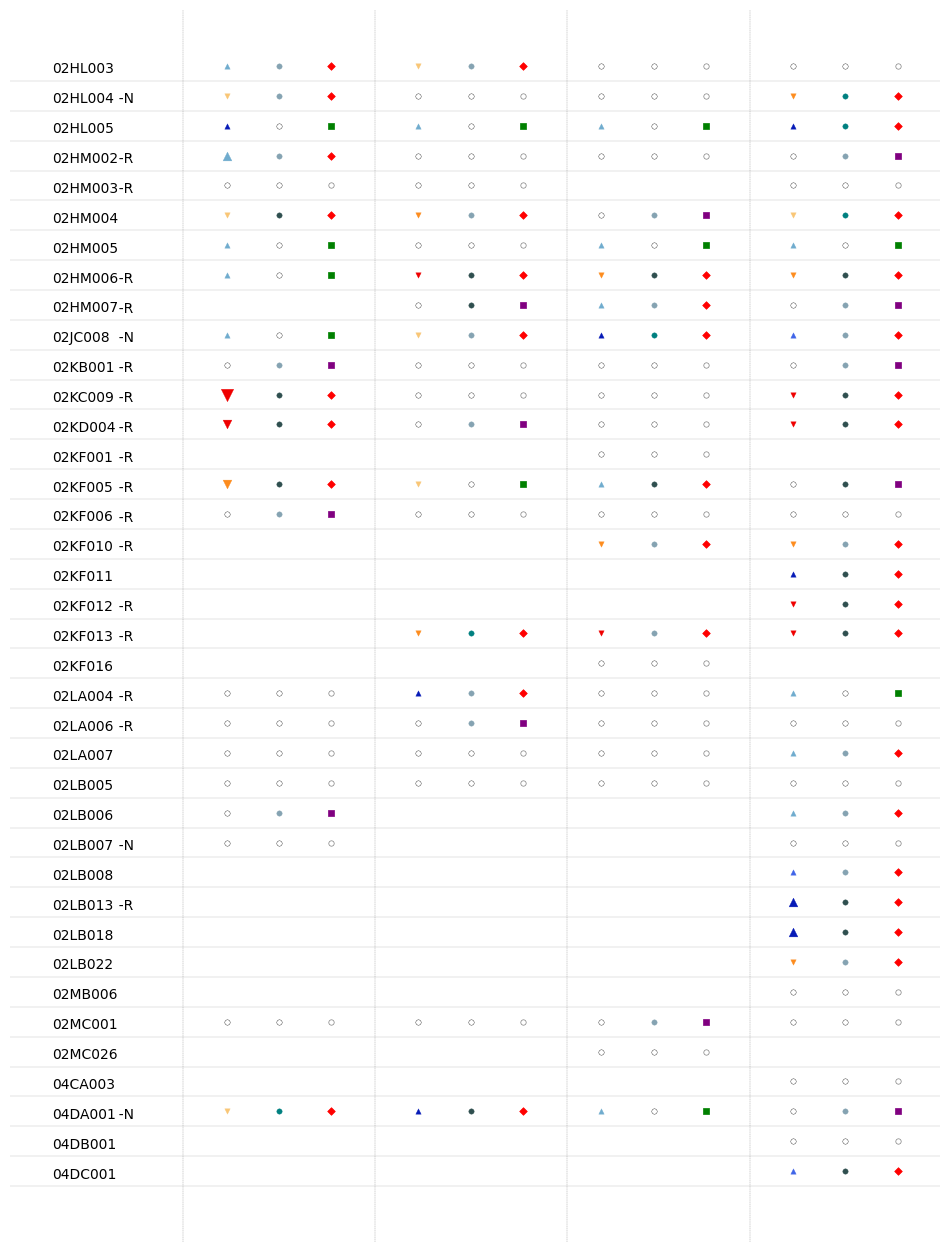

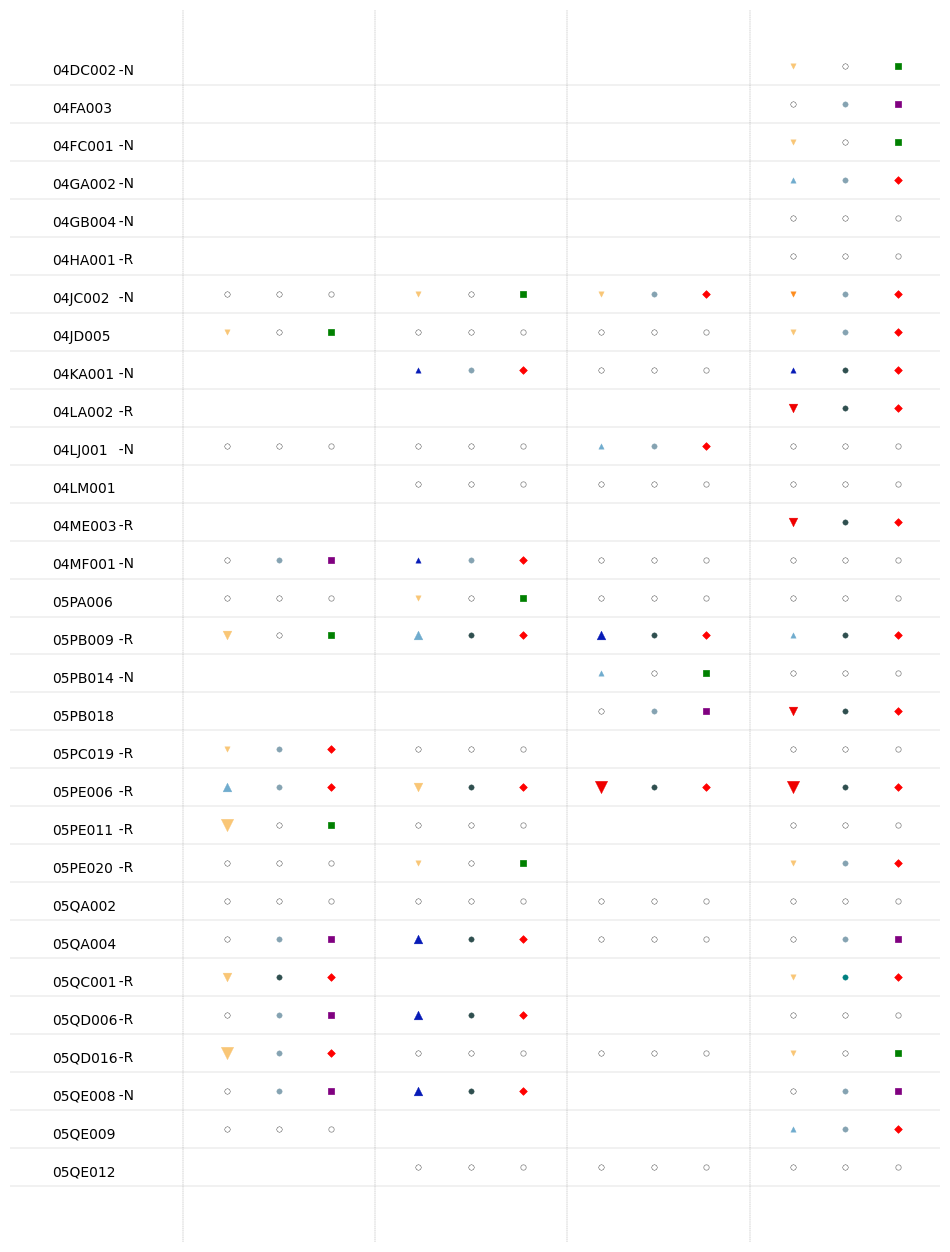

Loaded and trimmed image 'figure_1.png' as 'figure_1'
Loaded and trimmed image 'figure_2.png' as 'figure_2'
Loaded and trimmed image 'figure_3.png' as 'figure_3'
Loaded and trimmed image 'figure_4.png' as 'figure_4'
Loaded and trimmed image 'figure_5.png' as 'figure_5'
Loaded and trimmed image 'figure_6.png' as 'figure_6'
Loaded and trimmed image 'figure_7.png' as 'figure_7'


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\TIWARIDI\\OneDrive - Government of Ontario\\Documents\\WSCdata\\SOBR_FinalStations\\ResultTable\\Combined\\7DMF.png'

In [5]:
file_paths = [
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2000\allSOBRplot\MKnP_7dayminflow.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1980_2010\allSOBRplot\MKnP_7dayminflow.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1990_2020\allSOBRplot\MKnP_7dayminflow.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2020\allSOBRplot\MKnP_7dayminflow.csv"
]

result_dfs = [load_data(file_path) for file_path in file_paths]
result_df70, result_df80, result_df90, result_df2020 = result_dfs

# Assuming sobr_df and result_df70, result_df80, result_df90, result_df2020 are defined and populated DataFrames
stations_per_figure = 38
num_figures = -(-len(sobr_df) // stations_per_figure)
indm="7DMin"
# Now you can use this function in your loop
for fig_num in range(num_figures):
    start_idx = fig_num * stations_per_figure
    end_idx = min((fig_num + 1) * stations_per_figure, len(sobr_df))
    subset_df = sobr_df.iloc[start_idx:end_idx]
    fig, ax = plt.subplots(figsize=(12, 16))

    plot_data(ax, subset_df, result_df70, result_df80, result_df90, result_df2020,fig_num,indm)

    ax.axis('off')
    save_directory = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\7DMF'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, f'figure_{fig_num + 1}.png')
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
 
    plt.show() 
    
# Concatenating Images
folder_path = save_directory 
concatenated_image = st.concat_images(folder_path)

# concatenated_image.show()
save_path =  r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Combined\7DMF.png"
concatenated_image.save(save_path)


#count percentage and toatl station number for each category
results_count=count_perc(result_dfs)
# Save the results to a CSV file
file_name = 'trend_analysis_results_table.csv'
# Save the DataFrame to a CSV file
results_count.to_csv(os.path.join(save_directory, file_name))


In [ ]:
# 7 Day Minimum flow time

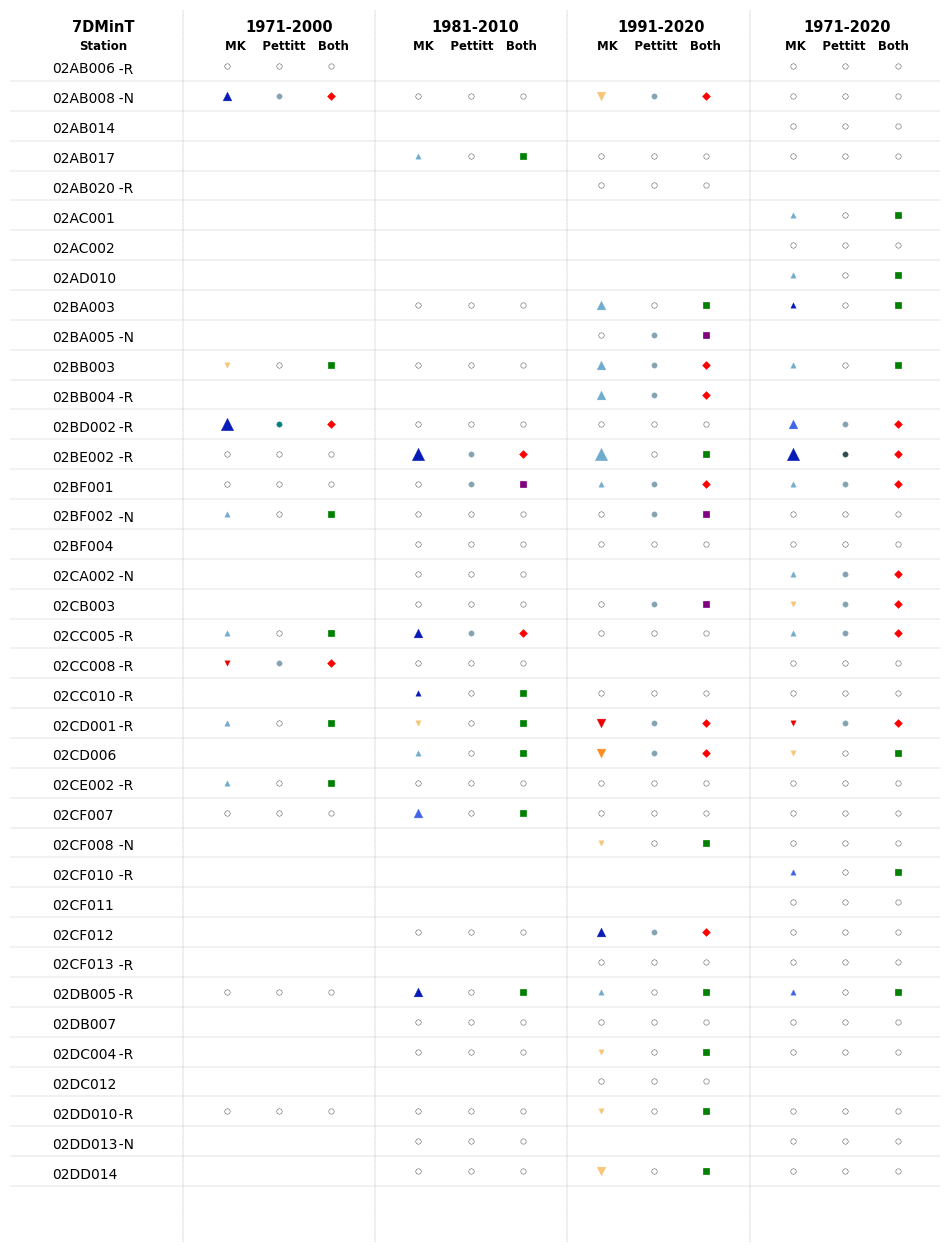

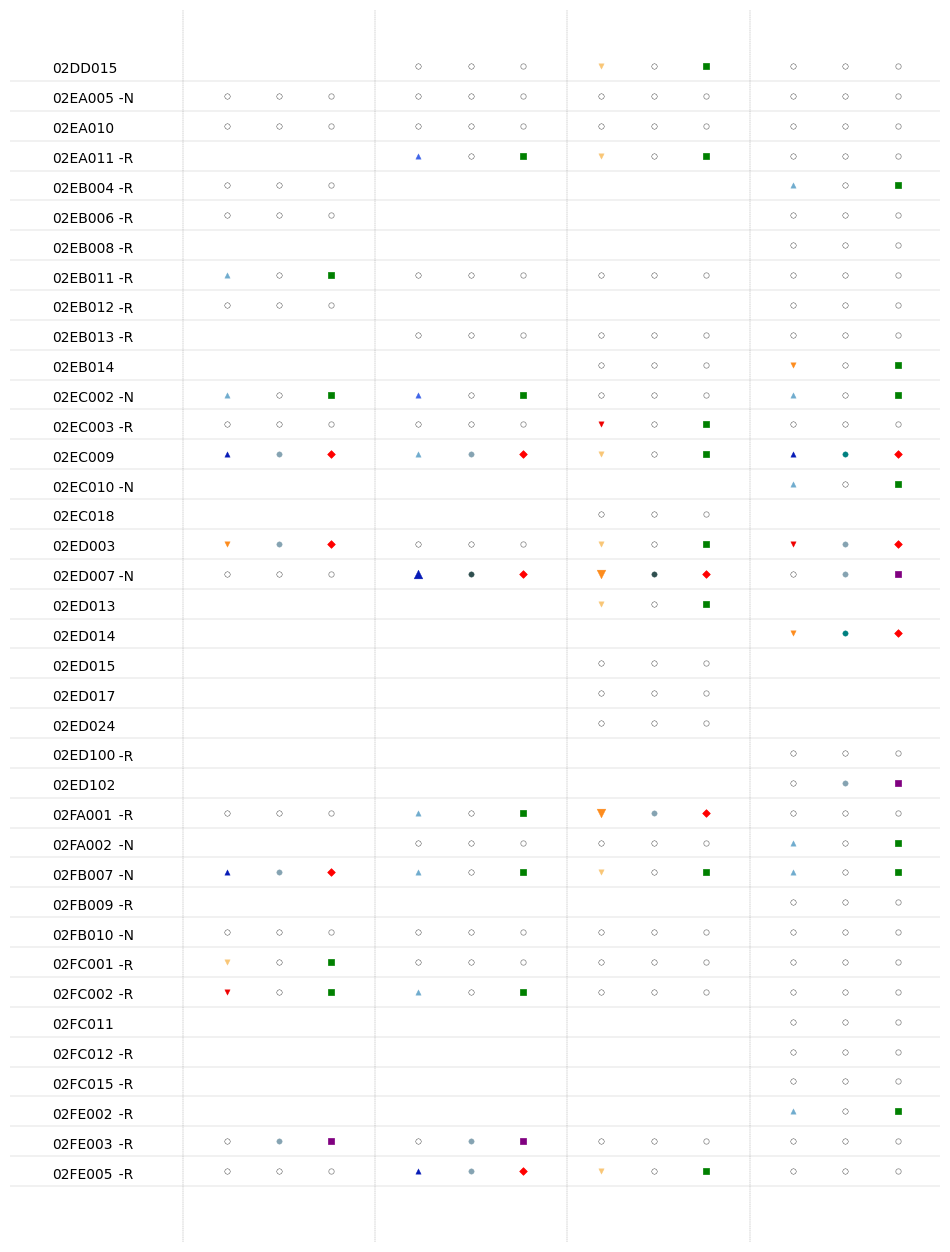

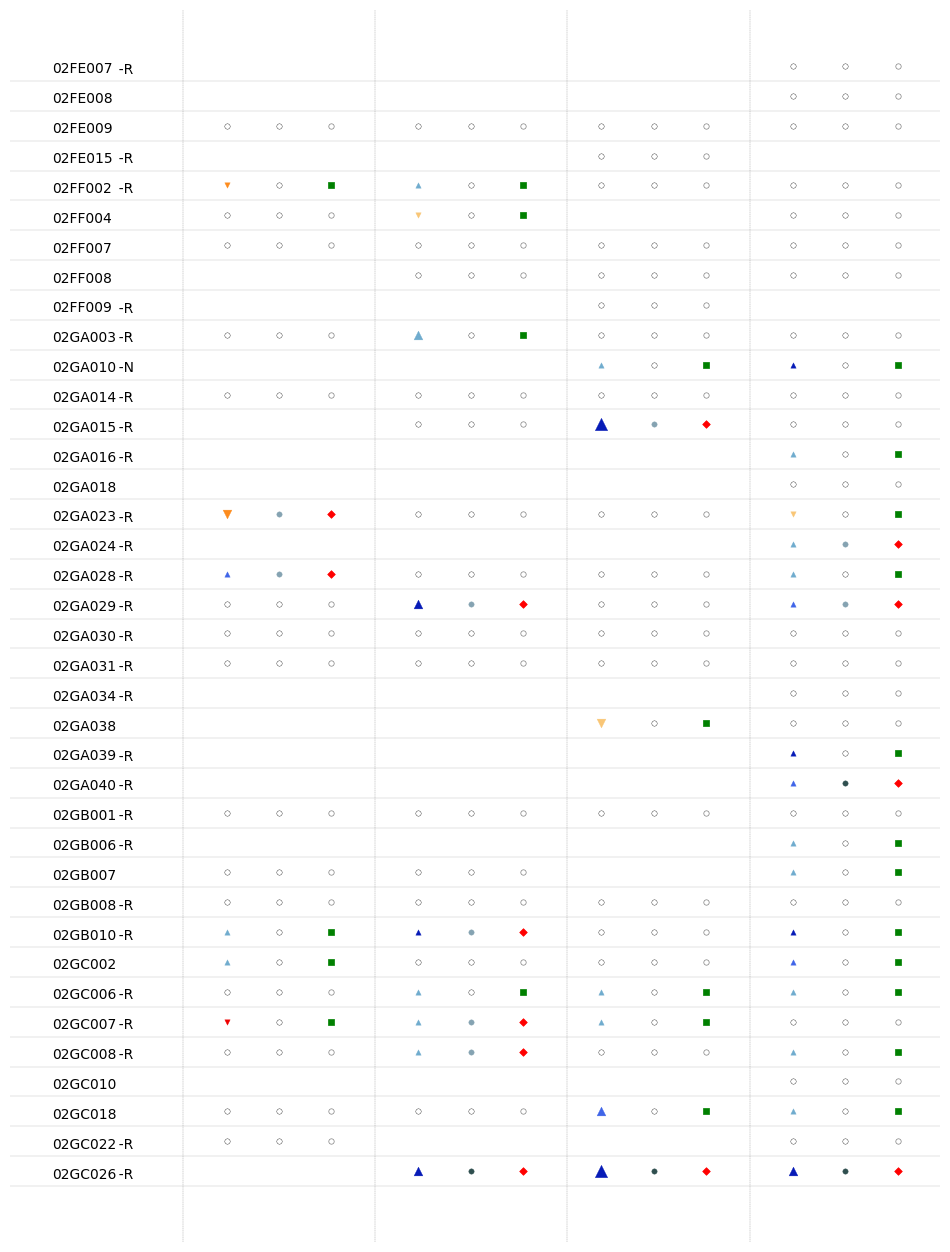

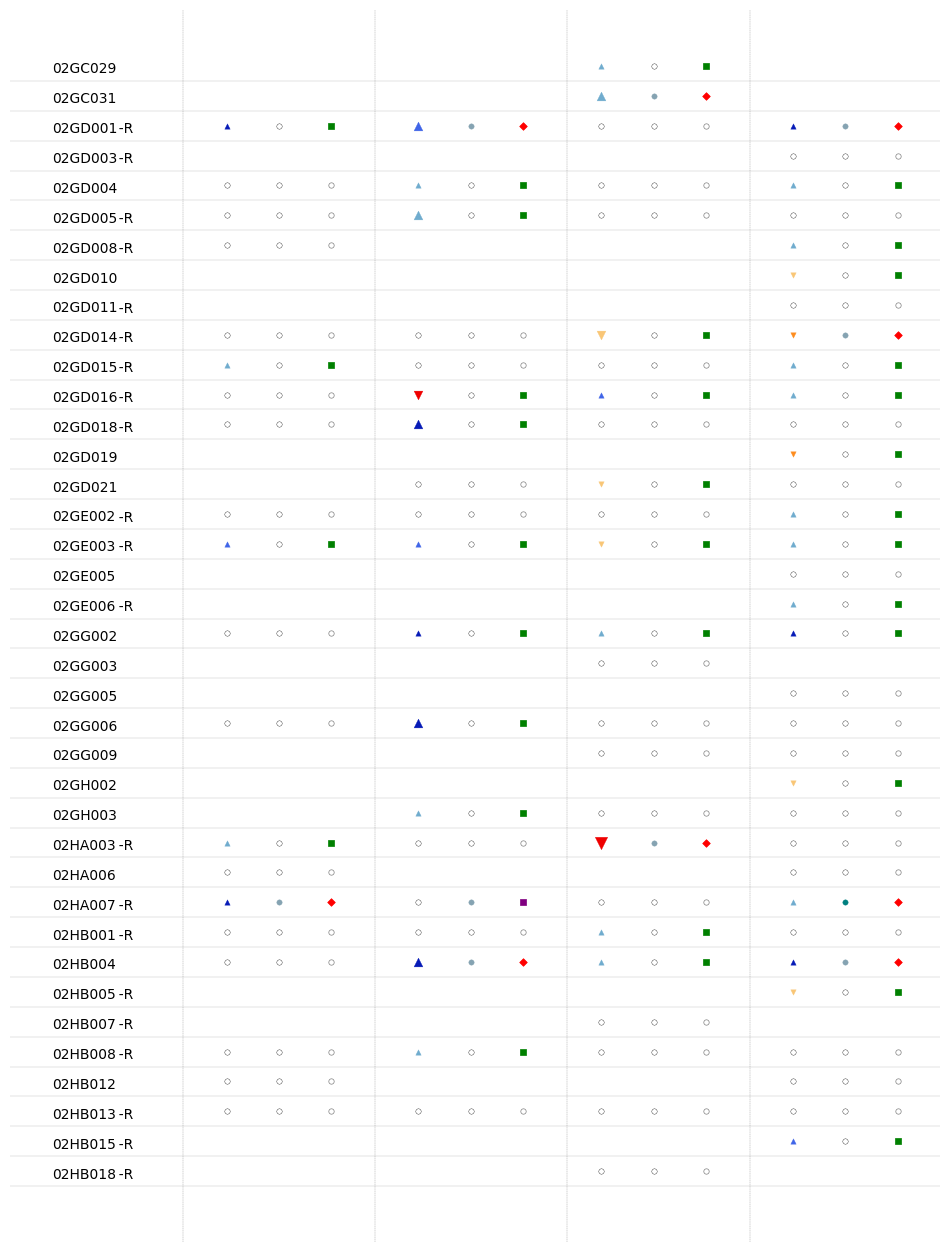

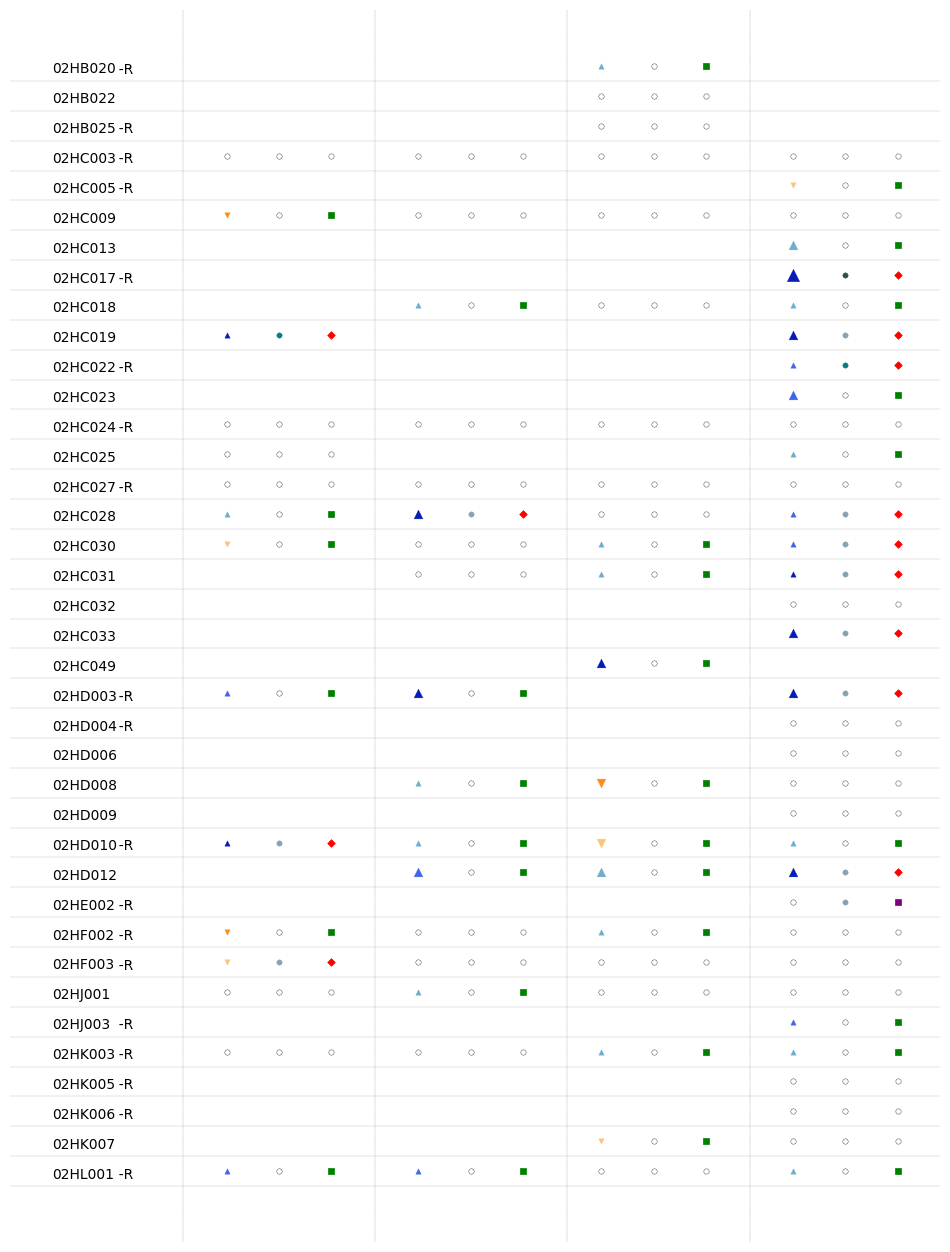

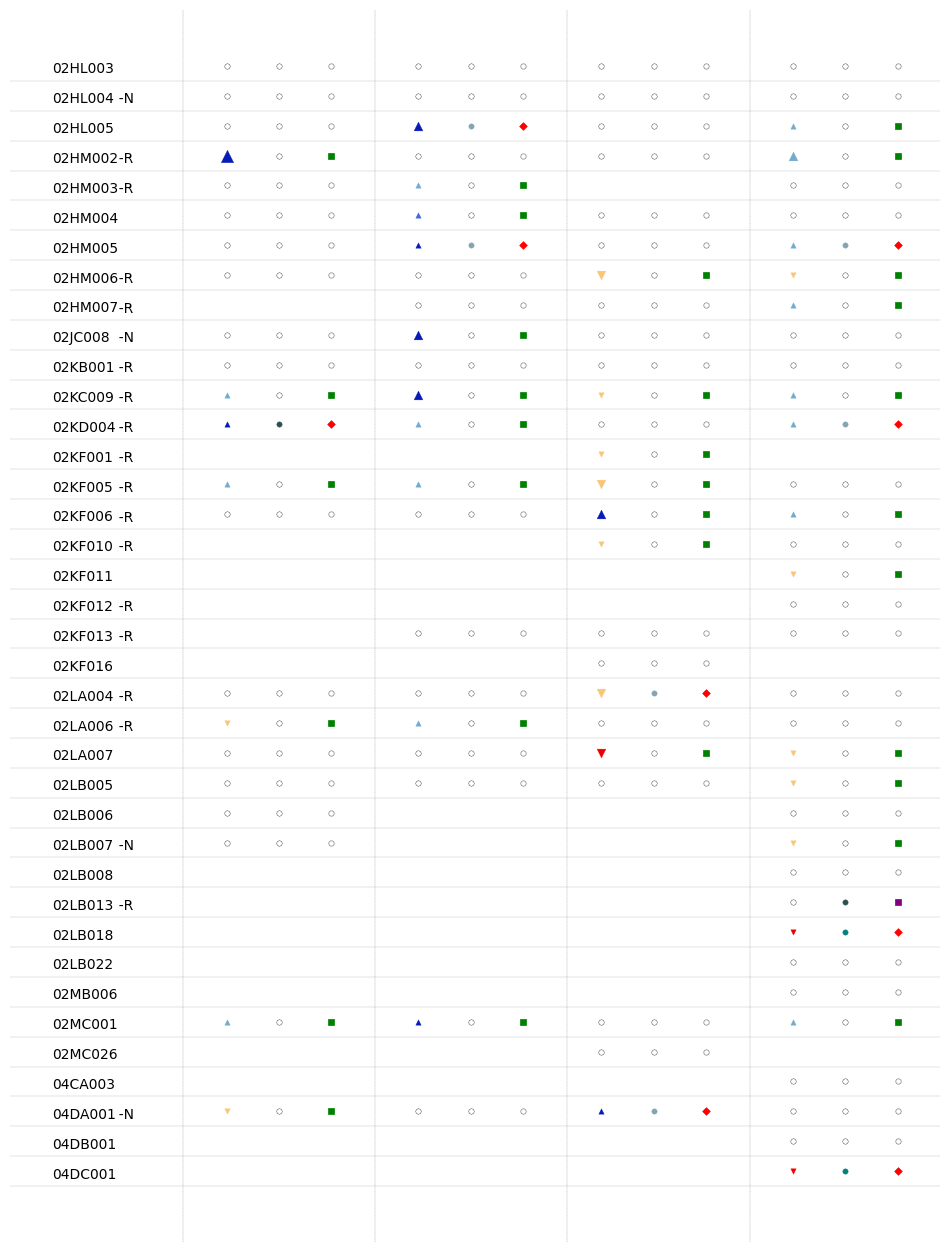

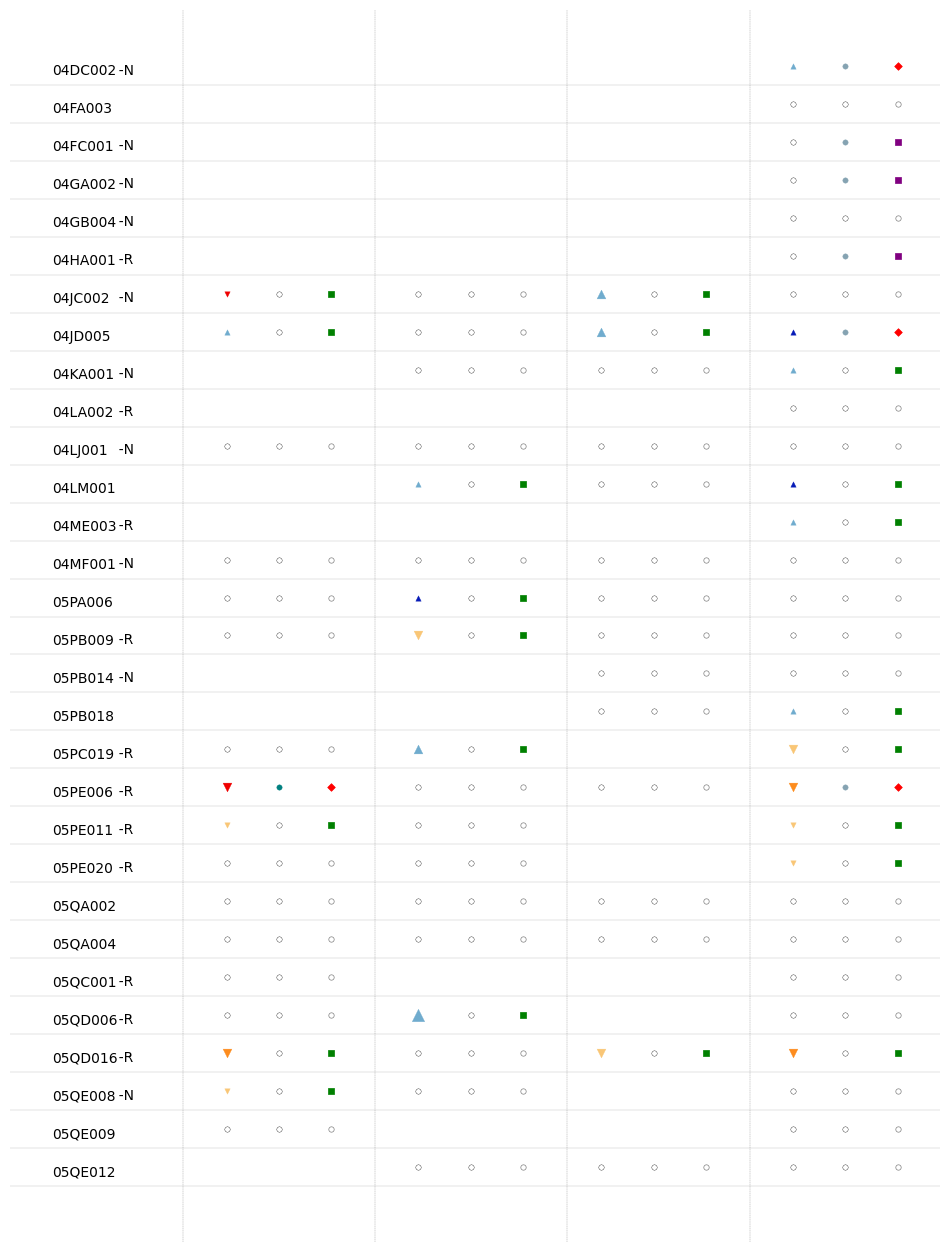

Loaded and trimmed image 'figure_1.png' as 'figure_1'
Loaded and trimmed image 'figure_2.png' as 'figure_2'
Loaded and trimmed image 'figure_3.png' as 'figure_3'
Loaded and trimmed image 'figure_4.png' as 'figure_4'
Loaded and trimmed image 'figure_5.png' as 'figure_5'
Loaded and trimmed image 'figure_6.png' as 'figure_6'
Loaded and trimmed image 'figure_7.png' as 'figure_7'


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\TIWARIDI\\OneDrive - Government of Ontario\\Documents\\WSCdata\\SOBR_FinalStations\\ResultTable\\Combined\\7DMFT.png'

In [6]:
file_paths = [
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2000\allSOBRplot\MKnP_7dayminflowTime.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1980_2010\allSOBRplot\MKnP_7dayminflowTime.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1990_2020\allSOBRplot\MKnP_7dayminflowTime.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2020\allSOBRplot\MKnP_7dayminflowTime.csv"
]

result_dfs = [load_datatime(file_path) for file_path in file_paths]
result_df70, result_df80, result_df90, result_df2020 = result_dfs

# Assuming sobr_df and result_df70, result_df80, result_df90, result_df2020 are defined and populated DataFrames
stations_per_figure = 38
num_figures = -(-len(sobr_df) // stations_per_figure)
indm="7DMinT"
# Now you can use this function in your loop
for fig_num in range(num_figures):
    start_idx = fig_num * stations_per_figure
    end_idx = min((fig_num + 1) * stations_per_figure, len(sobr_df))
    subset_df = sobr_df.iloc[start_idx:end_idx]
    fig, ax = plt.subplots(figsize=(12, 16))

    plot_data(ax, subset_df, result_df70, result_df80, result_df90, result_df2020,fig_num,indm)

    ax.axis('off')
    save_directory = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\7DMFT'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, f'figure_{fig_num + 1}.png')
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
 
    plt.show() 
    
# Concatenating Images
folder_path = save_directory 
concatenated_image = st.concat_images(folder_path)

# concatenated_image.show()
save_path =  r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Combined\7DMFT.png"
concatenated_image.save(save_path)

#count percentage and toatl station number for each category
results_count=count_perc(result_dfs)
# Save the results to a CSV file
file_name = 'trend_analysis_results_table.csv'
# Save the DataFrame to a CSV file
results_count.to_csv(os.path.join(save_directory, file_name))


# ACV 

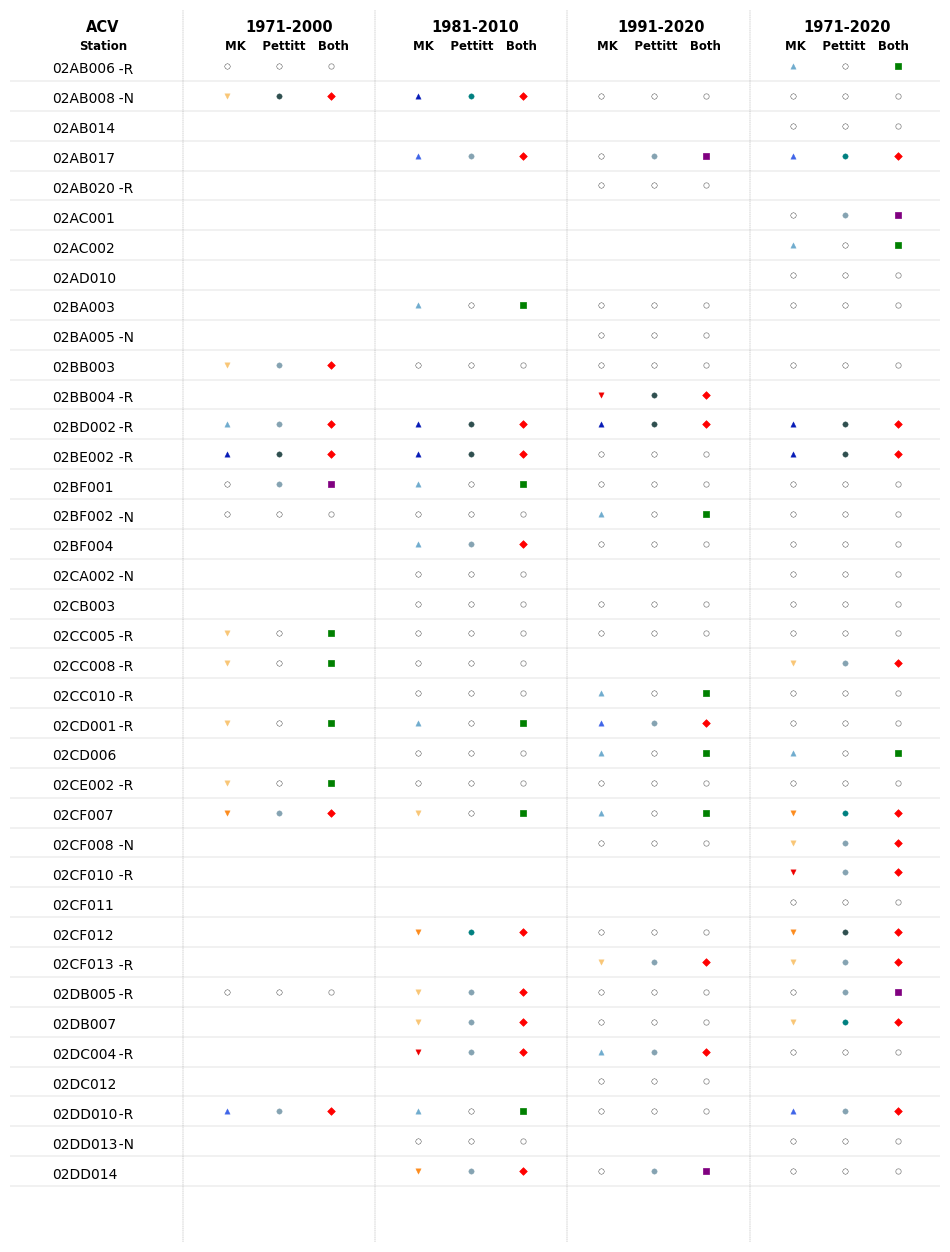

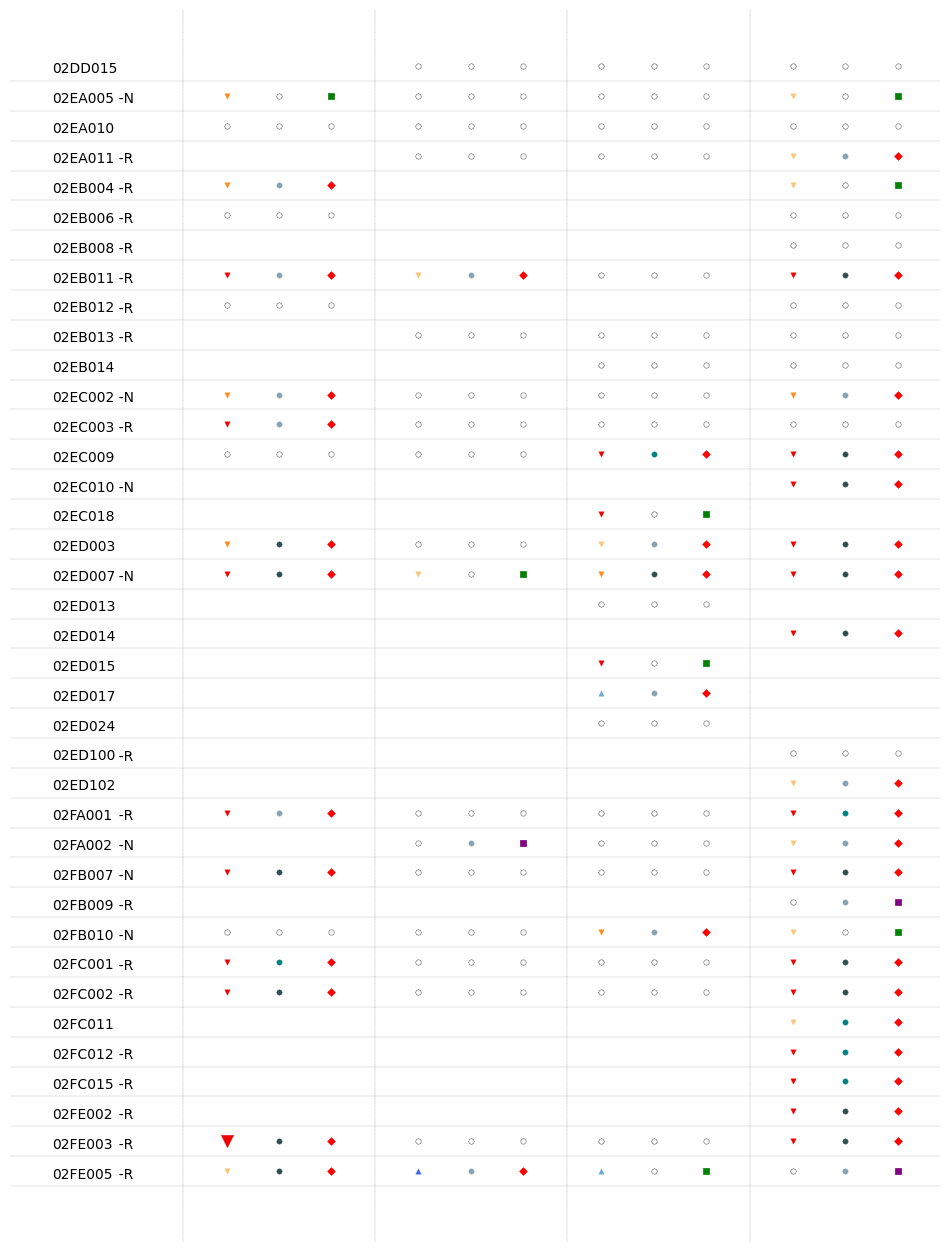

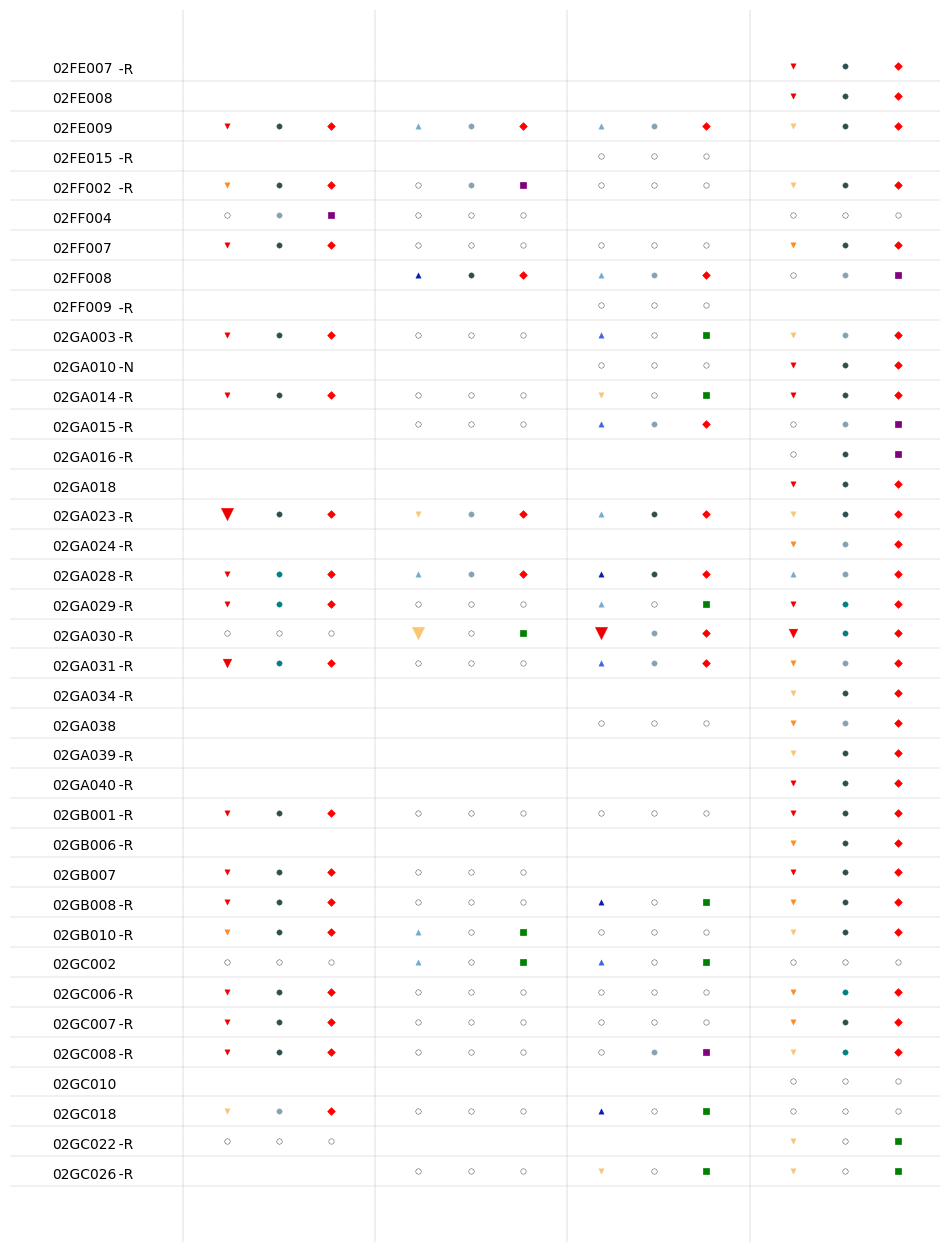

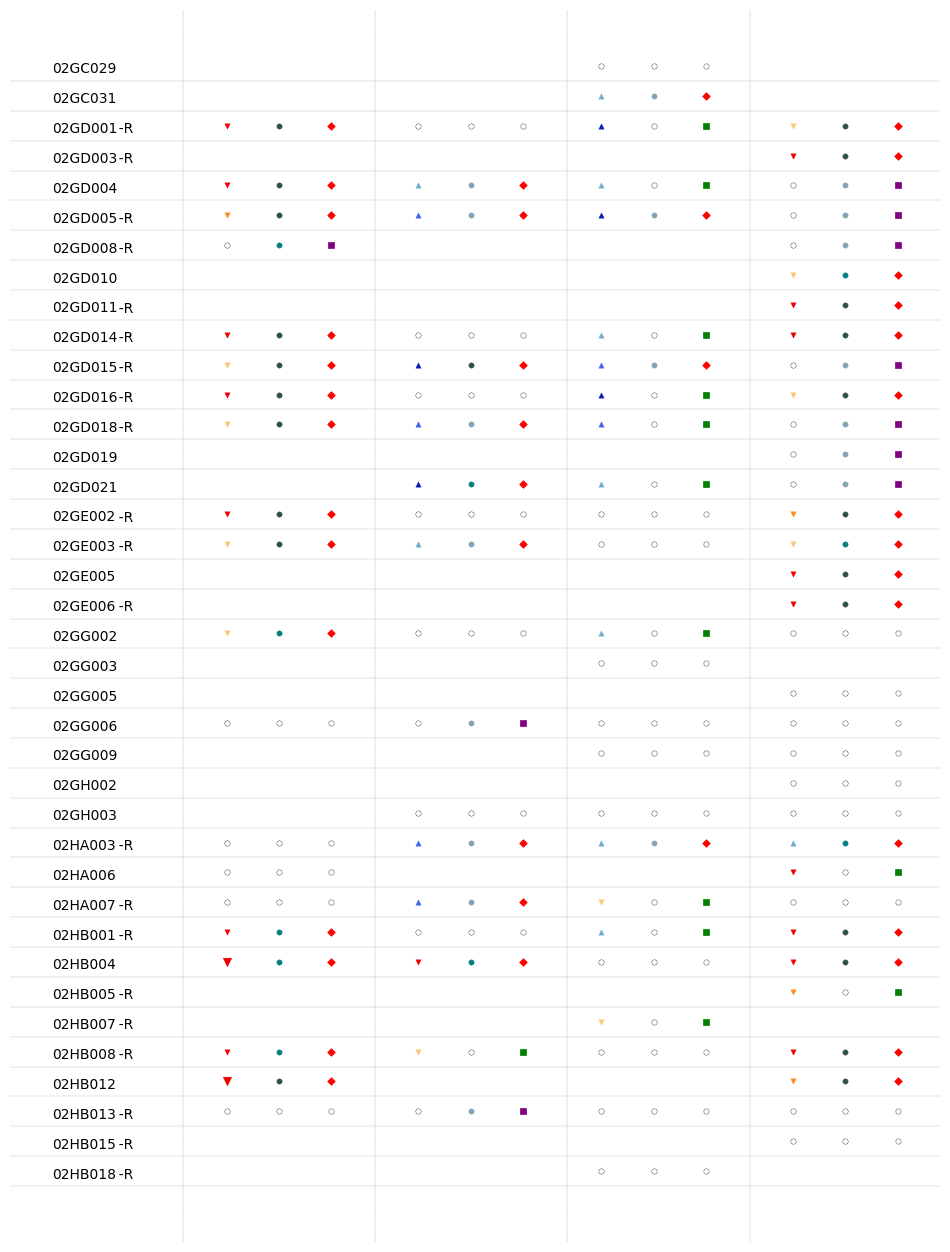

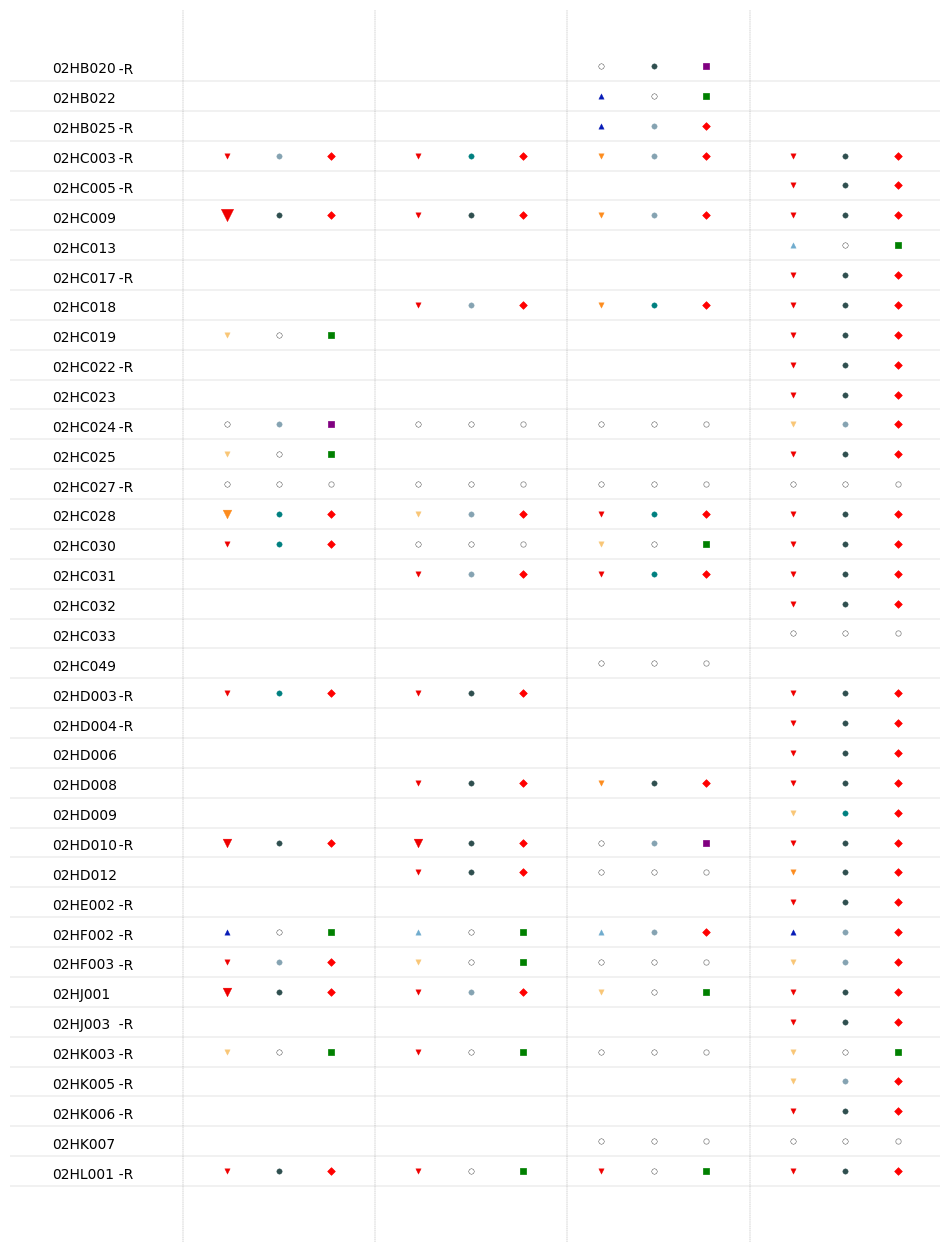

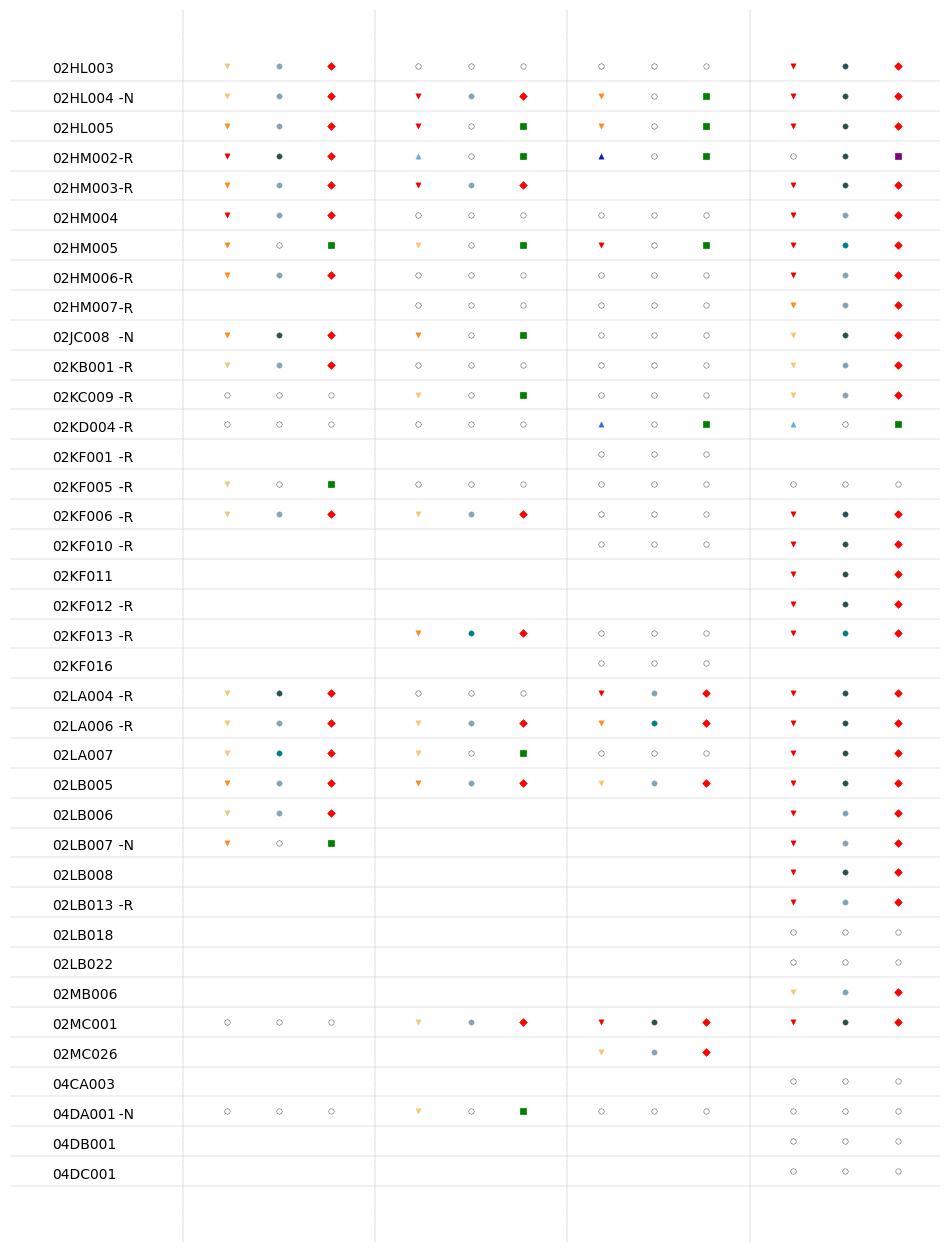

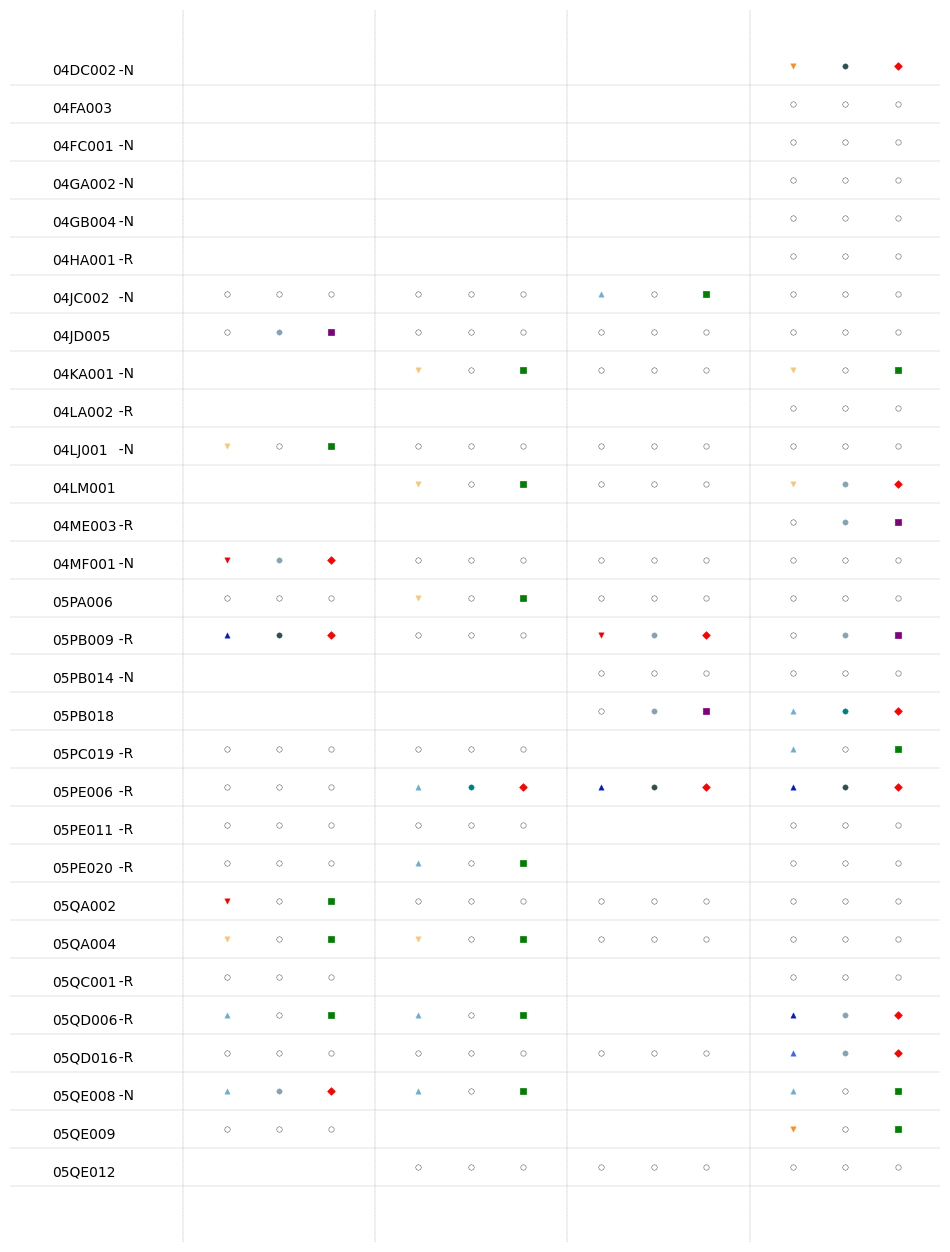

Loaded and trimmed image 'figure_1.png' as 'figure_1'
Loaded and trimmed image 'figure_2.png' as 'figure_2'
Loaded and trimmed image 'figure_3.png' as 'figure_3'
Loaded and trimmed image 'figure_4.png' as 'figure_4'
Loaded and trimmed image 'figure_5.png' as 'figure_5'
Loaded and trimmed image 'figure_6.png' as 'figure_6'
Loaded and trimmed image 'figure_7.png' as 'figure_7'


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\TIWARIDI\\OneDrive - Government of Ontario\\Documents\\WSCdata\\SOBR_FinalStations\\ResultTable\\Combined\\ACV.png'

In [7]:
file_paths = [
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2000\allSOBRplot\MKnP_ACV.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1980_2010\allSOBRplot\MKnP_ACV.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1990_2020\allSOBRplot\MKnP_ACV.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2020\allSOBRplot\MKnP_ACV.csv"
]

result_dfs = [load_data(file_path) for file_path in file_paths]
result_df70, result_df80, result_df90, result_df2020 = result_dfs

# Assuming sobr_df and result_df70, result_df80, result_df90, result_df2020 are defined and populated DataFrames
stations_per_figure = 38
num_figures = -(-len(sobr_df) // stations_per_figure)
indm="ACV"
# Now you can use this function in your loop
for fig_num in range(num_figures):
    start_idx = fig_num * stations_per_figure
    end_idx = min((fig_num + 1) * stations_per_figure, len(sobr_df))
    subset_df = sobr_df.iloc[start_idx:end_idx]
    fig, ax = plt.subplots(figsize=(12, 16))

    plot_data(ax, subset_df, result_df70, result_df80, result_df90, result_df2020,fig_num,indm)

    ax.axis('off')
    save_directory = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\ACV'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, f'figure_{fig_num + 1}.png')
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
 
    plt.show() 
    
# Concatenating Images
folder_path = save_directory 
concatenated_image = st.concat_images(folder_path)

# concatenated_image.show()
save_path =  r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Combined\ACV.png"
concatenated_image.save(save_path)

#count percentage and toatl station number for each category
results_count=count_perc(result_dfs)
# Save the results to a CSV file
file_name = 'trend_analysis_results_table.csv'
# Save the DataFrame to a CSV file
results_count.to_csv(os.path.join(save_directory, file_name))

# RBI

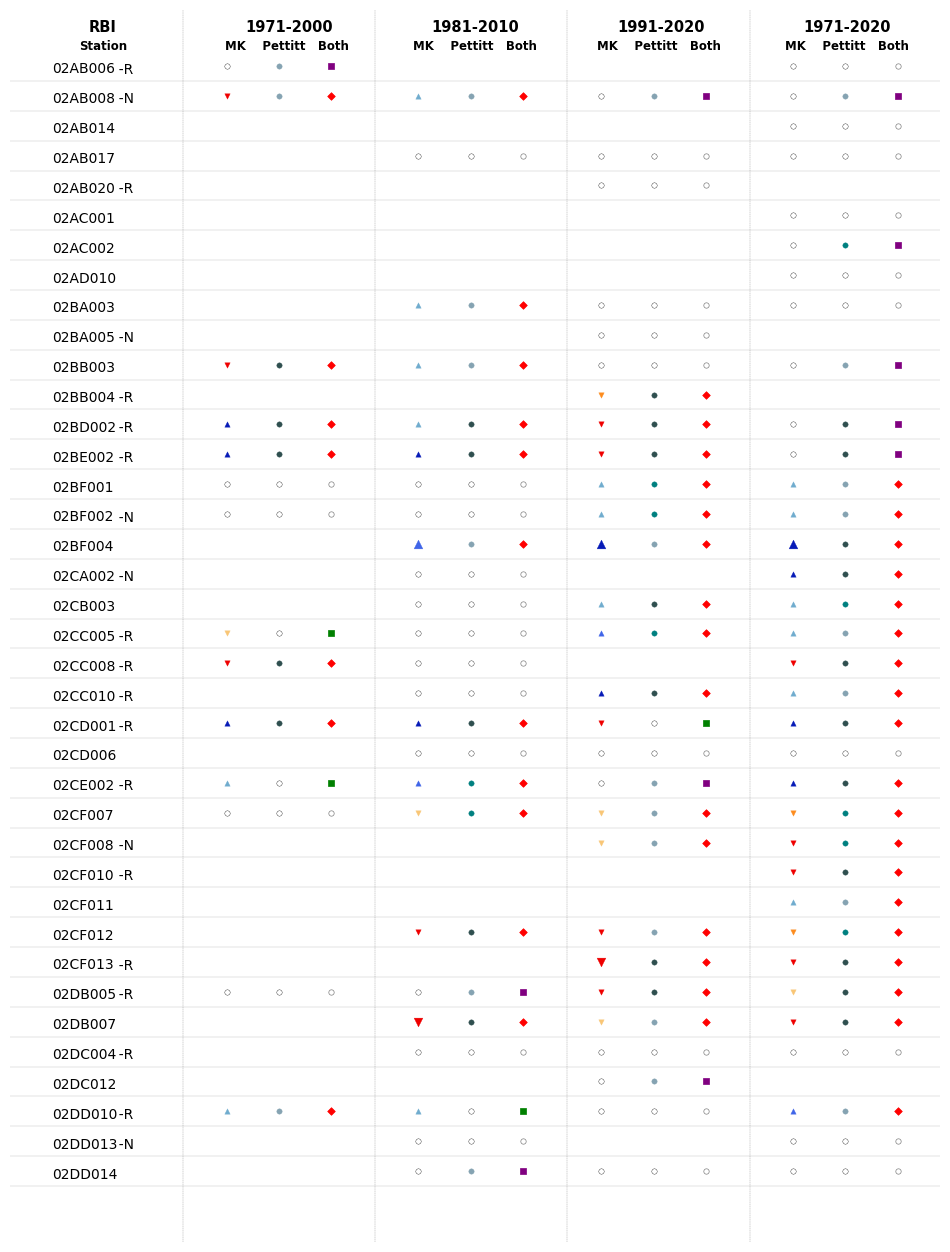

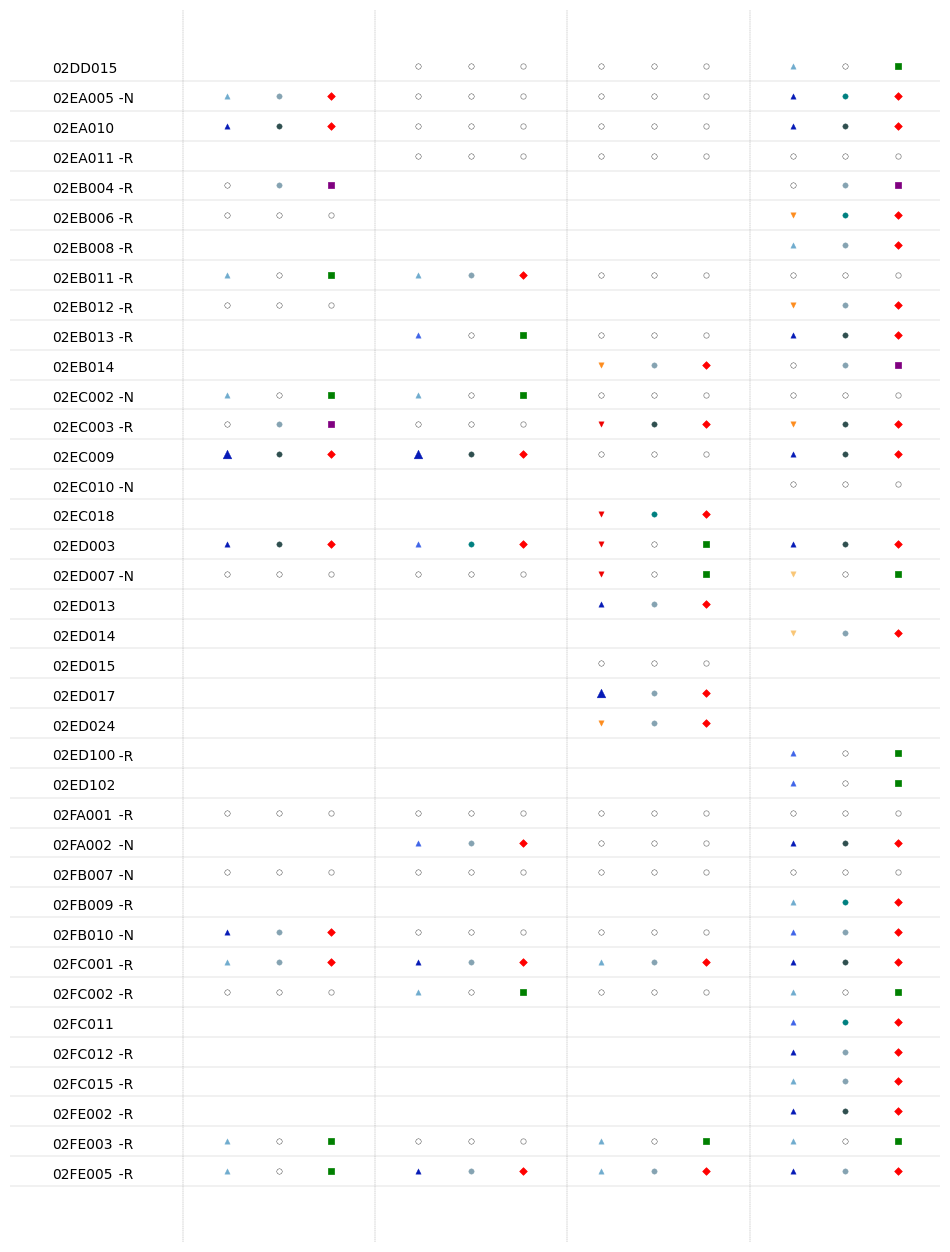

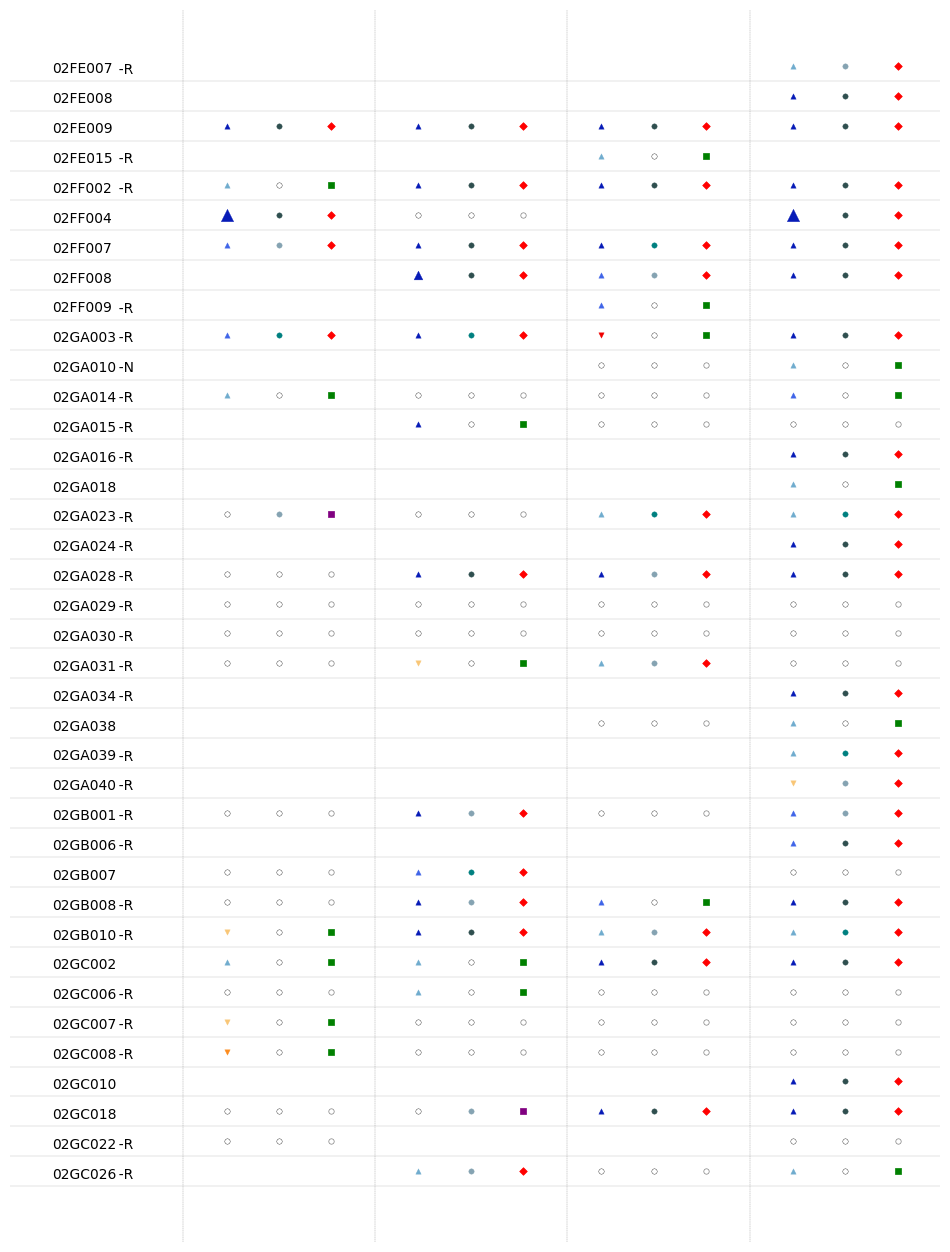

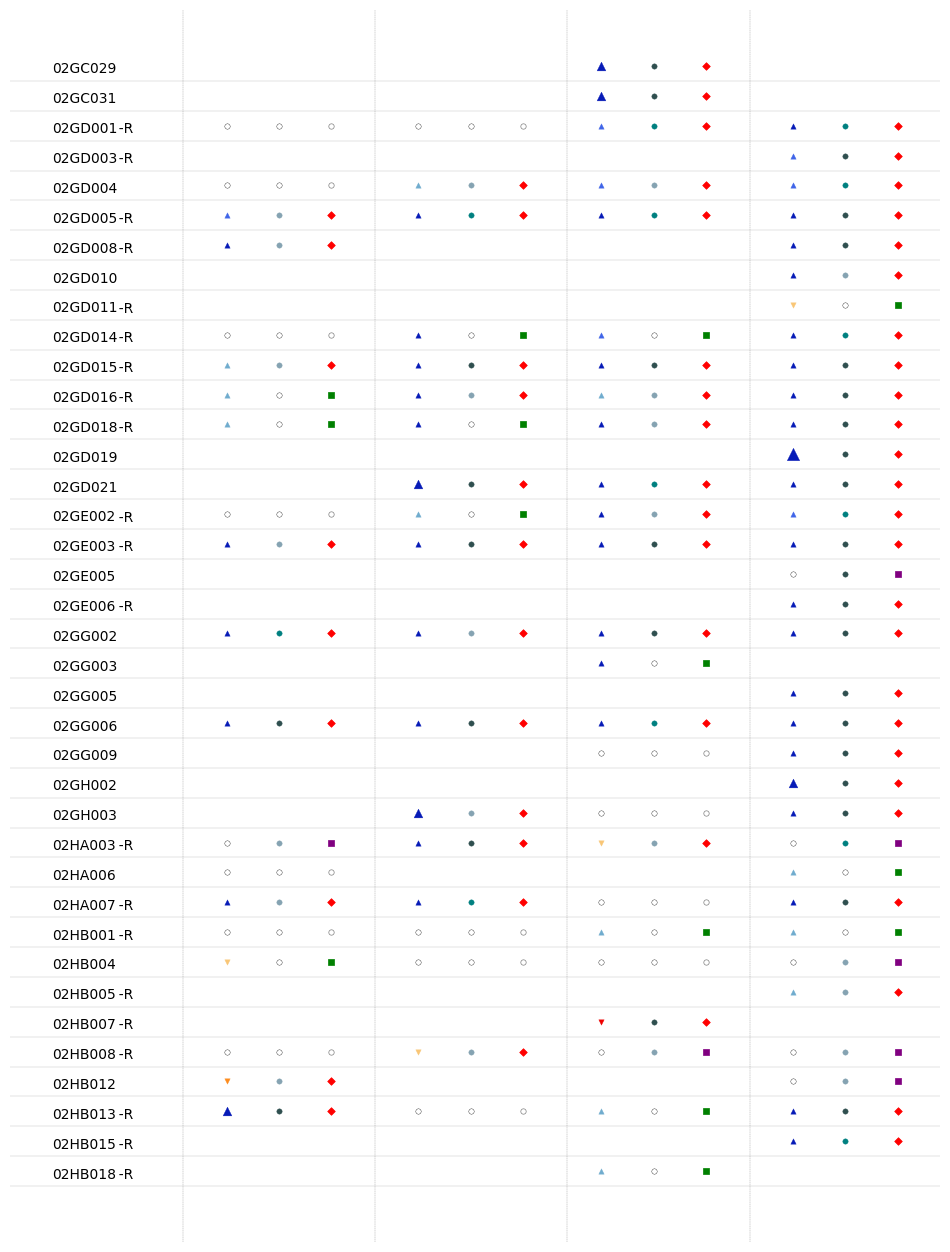

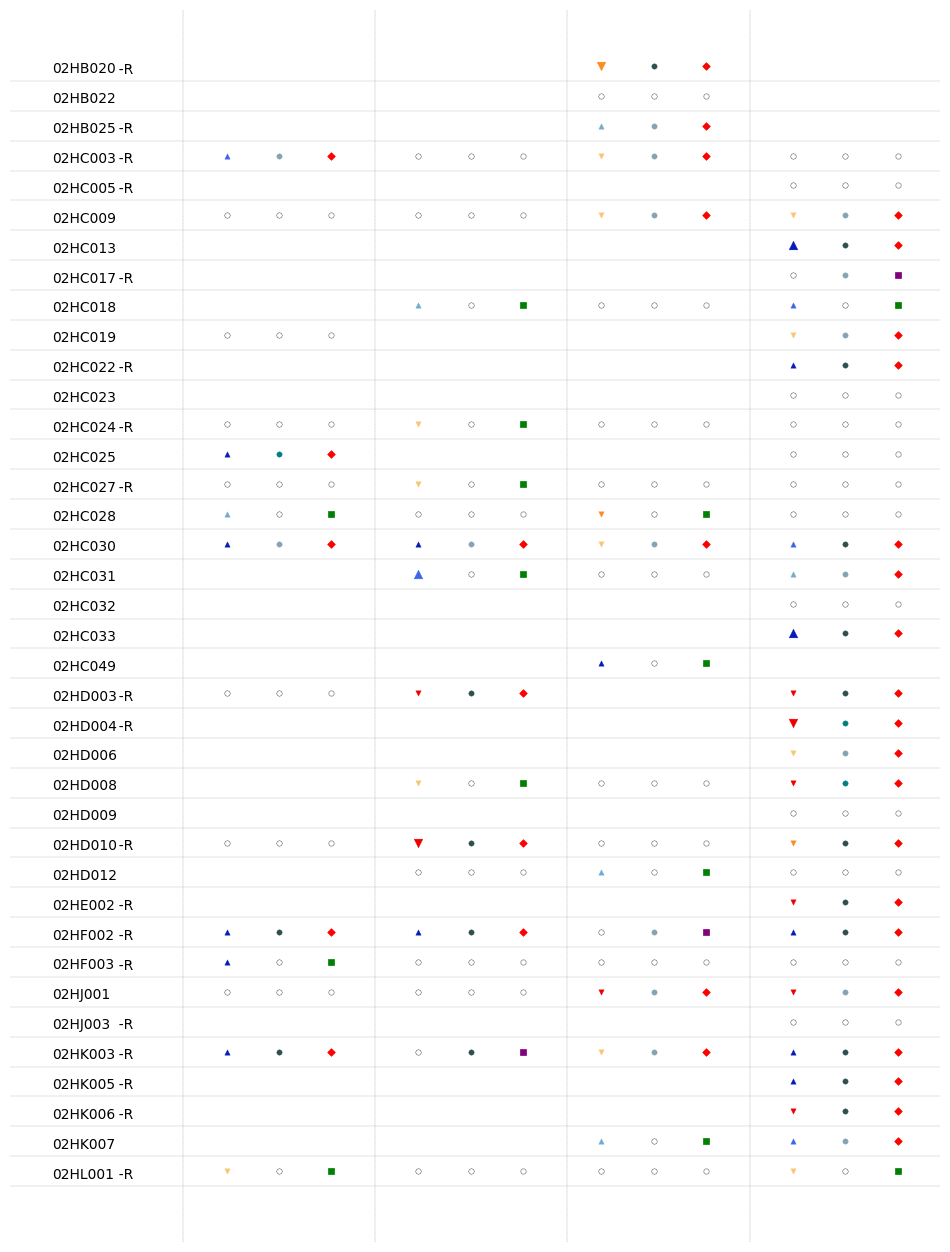

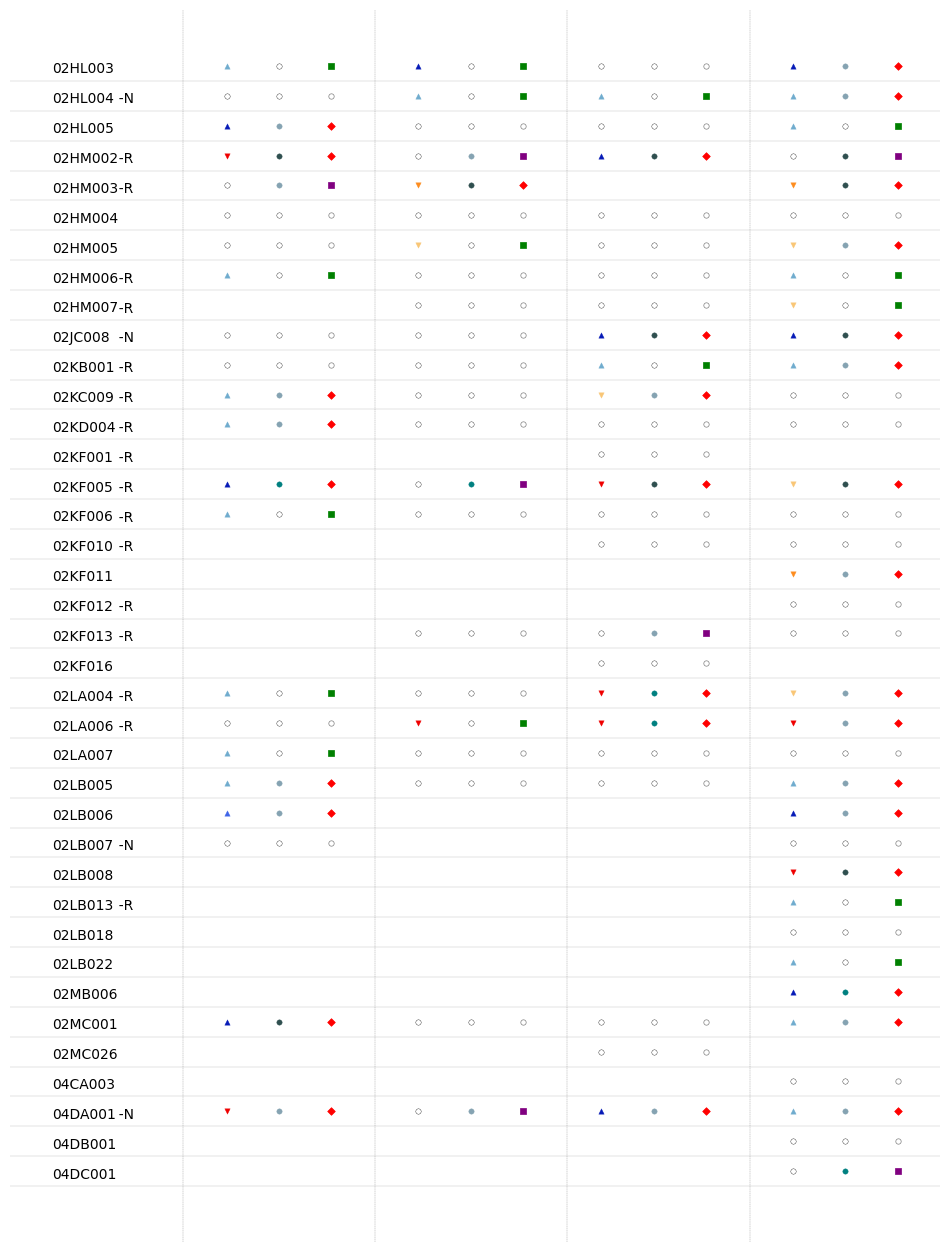

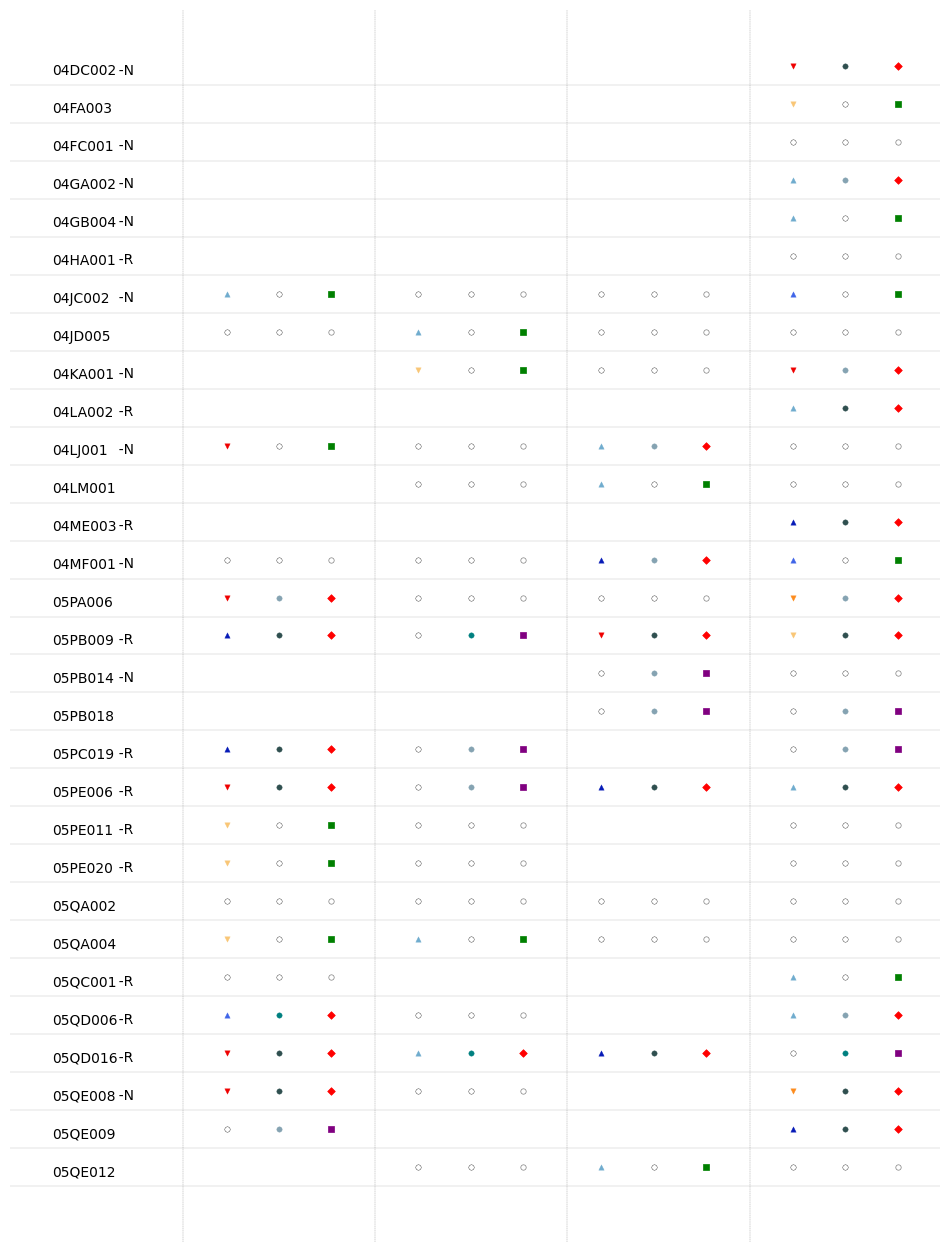

Loaded and trimmed image 'figure_1.png' as 'figure_1'
Loaded and trimmed image 'figure_2.png' as 'figure_2'
Loaded and trimmed image 'figure_3.png' as 'figure_3'
Loaded and trimmed image 'figure_4.png' as 'figure_4'
Loaded and trimmed image 'figure_5.png' as 'figure_5'
Loaded and trimmed image 'figure_6.png' as 'figure_6'
Loaded and trimmed image 'figure_7.png' as 'figure_7'


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\TIWARIDI\\OneDrive - Government of Ontario\\Documents\\WSCdata\\SOBR_FinalStations\\ResultTable\\Combined\\RBI.png'

In [8]:
file_paths = [
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2000\allSOBRplot\MKnP_RBI.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1980_2010\allSOBRplot\MKnP_RBI.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1990_2020\allSOBRplot\MKnP_RBI.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2020\allSOBRplot\MKnP_RBI.csv"
]

result_dfs = [load_data(file_path) for file_path in file_paths]
result_df70, result_df80, result_df90, result_df2020 = result_dfs

# Assuming sobr_df and result_df70, result_df80, result_df90, result_df2020 are defined and populated DataFrames
stations_per_figure = 38
num_figures = -(-len(sobr_df) // stations_per_figure)
indm="RBI"
# Now you can use this function in your loop
for fig_num in range(num_figures):
    start_idx = fig_num * stations_per_figure
    end_idx = min((fig_num + 1) * stations_per_figure, len(sobr_df))
    subset_df = sobr_df.iloc[start_idx:end_idx]
    fig, ax = plt.subplots(figsize=(12, 16))

    plot_data(ax, subset_df, result_df70, result_df80, result_df90, result_df2020,fig_num,indm)

    ax.axis('off')
    save_directory = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\RBI'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, f'figure_{fig_num + 1}.png')
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
 
    plt.show() 
    
# Concatenating Images
folder_path = save_directory 
concatenated_image = st.concat_images(folder_path)

# concatenated_image.show()
save_path =  r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Combined\RBI.png"
concatenated_image.save(save_path)

#count percentage and toatl station number for each category
results_count=count_perc(result_dfs)
# Save the results to a CSV file
file_name = 'trend_analysis_results_table.csv'
# Save the DataFrame to a CSV file
results_count.to_csv(os.path.join(save_directory, file_name))

# Mean Annual Discharge

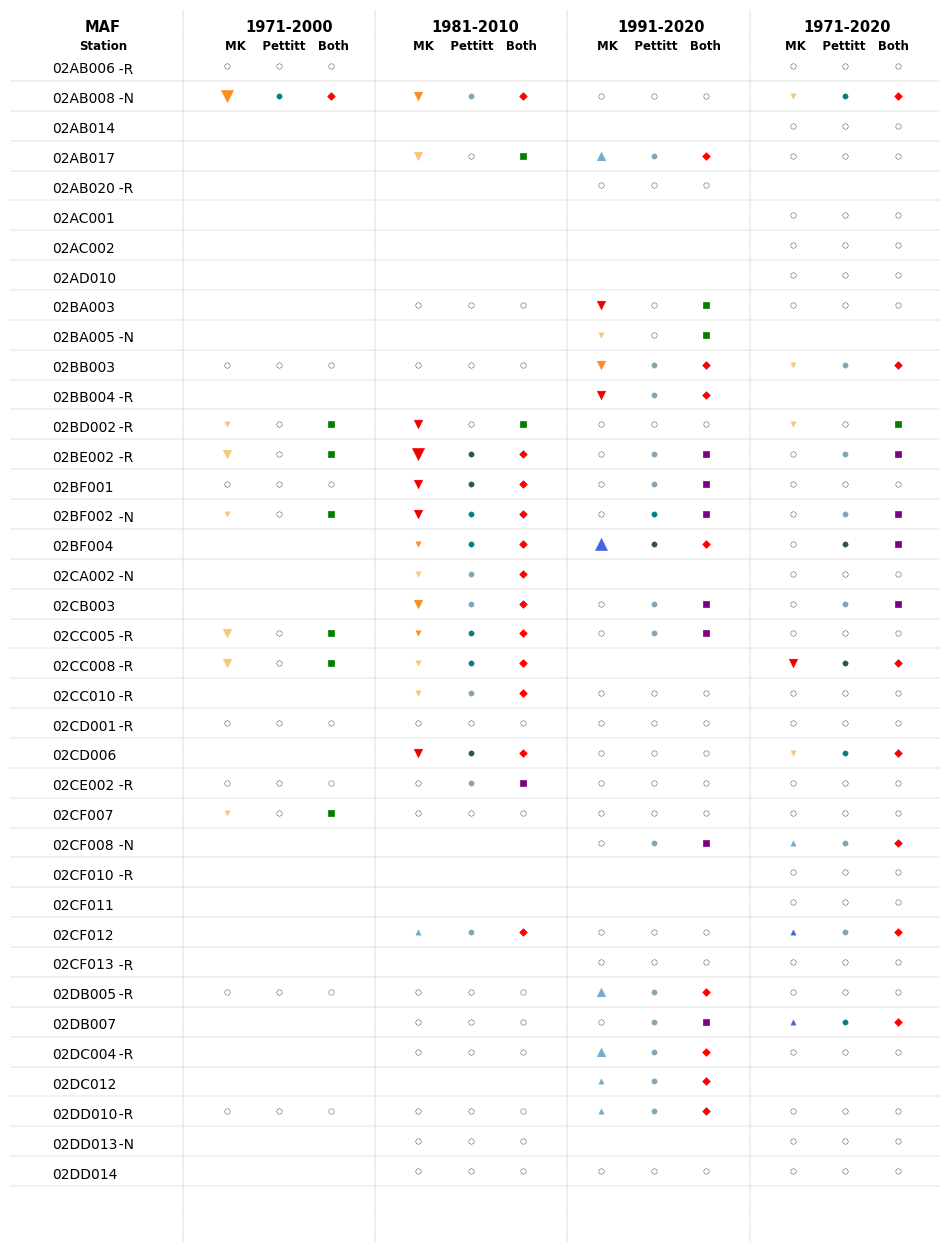

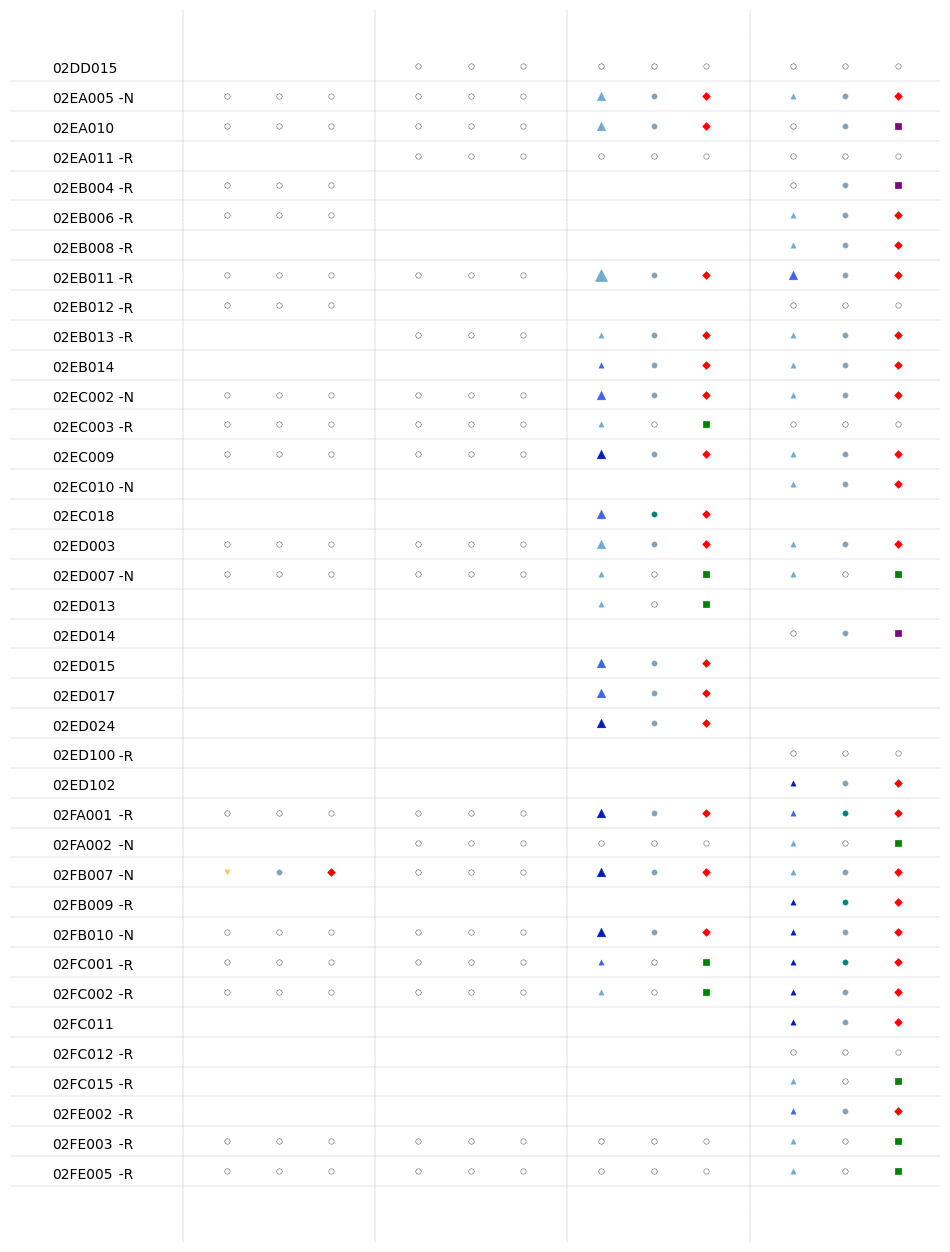

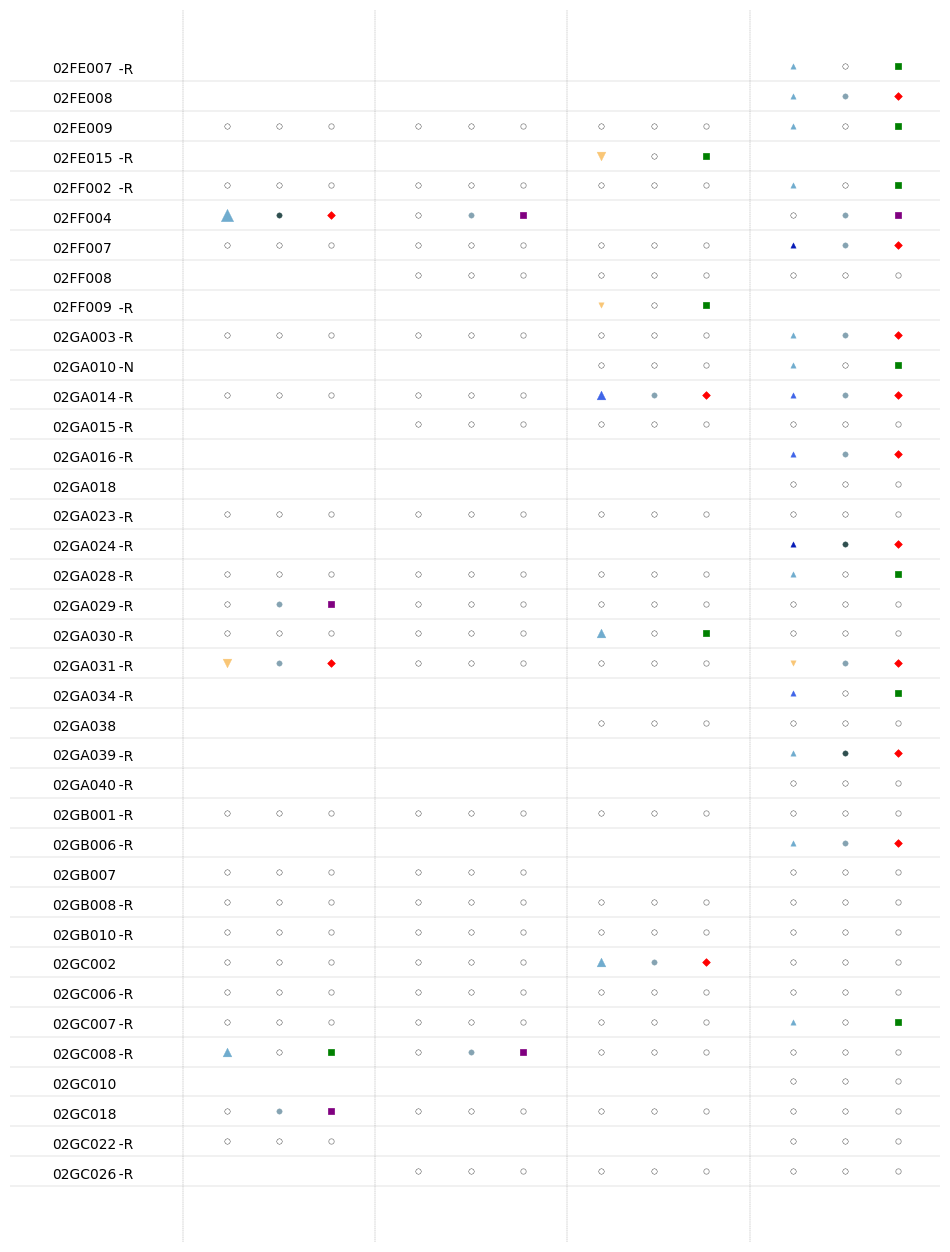

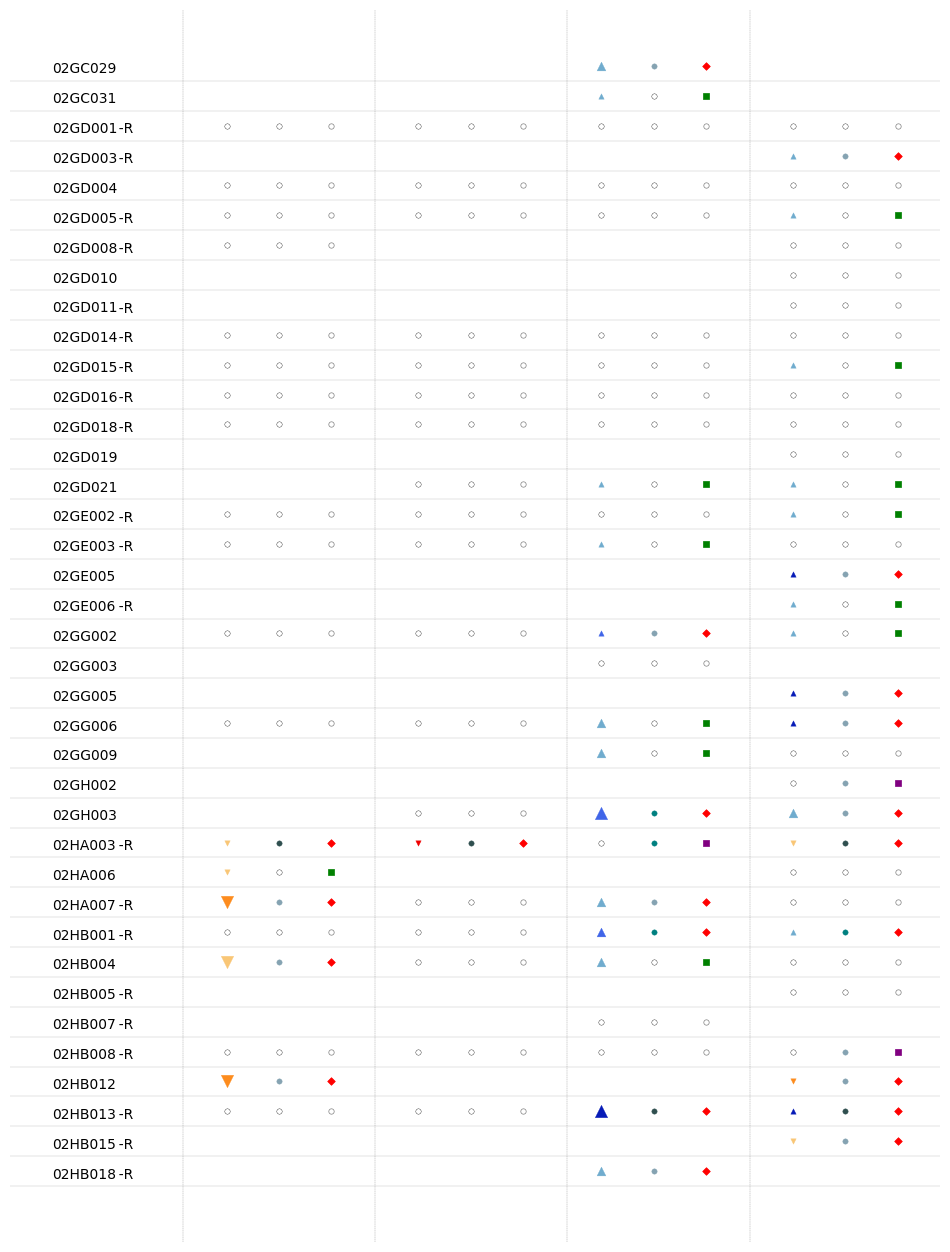

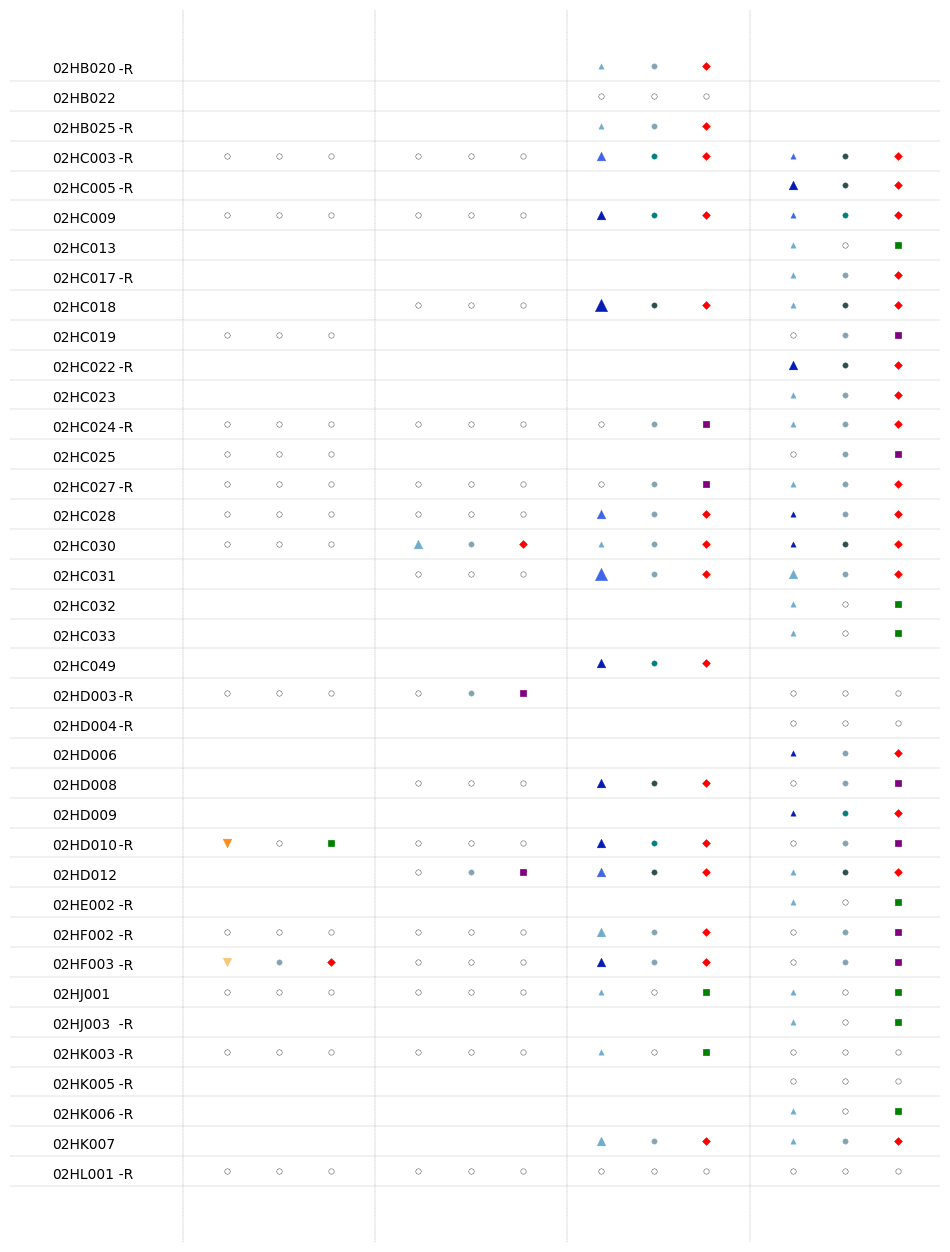

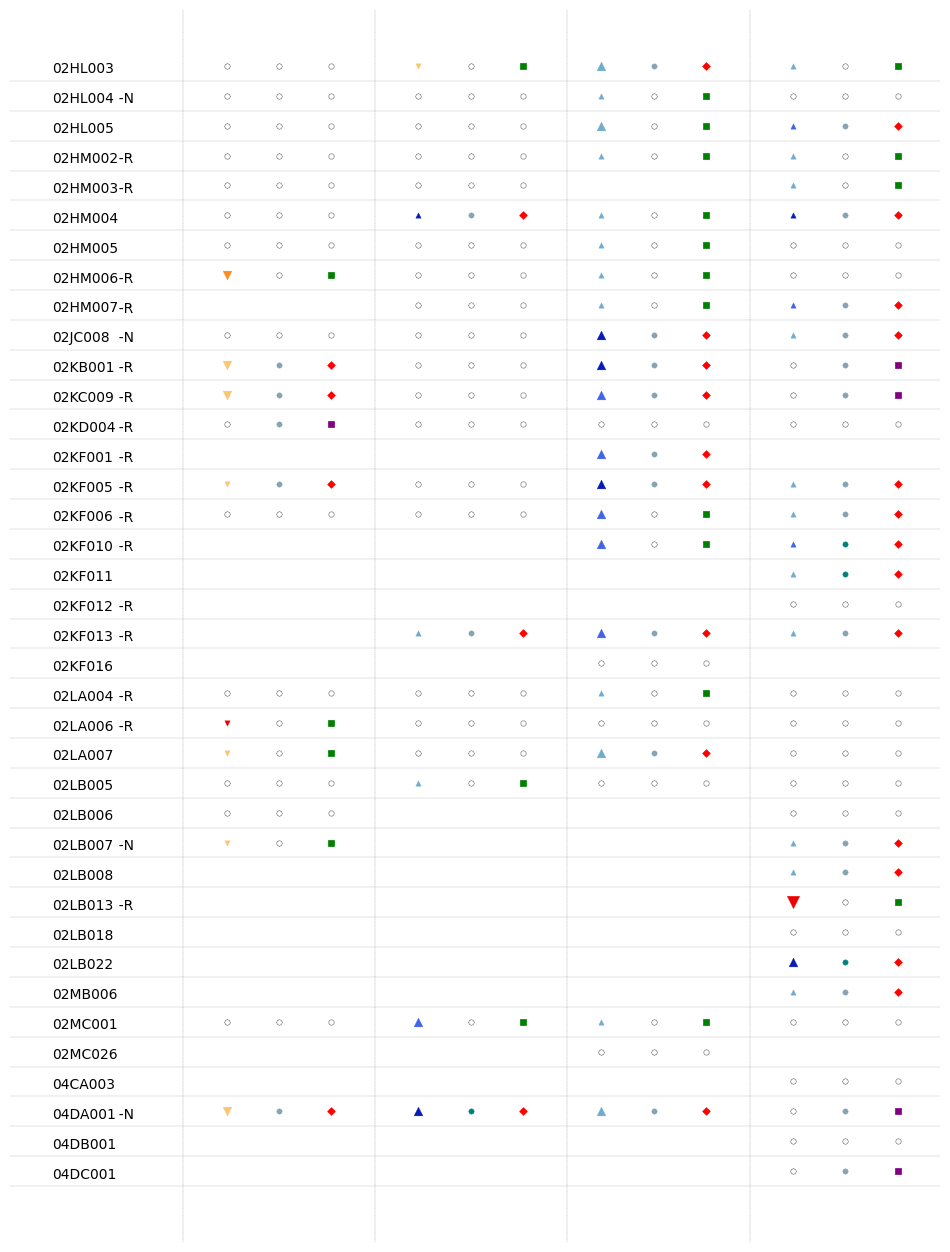

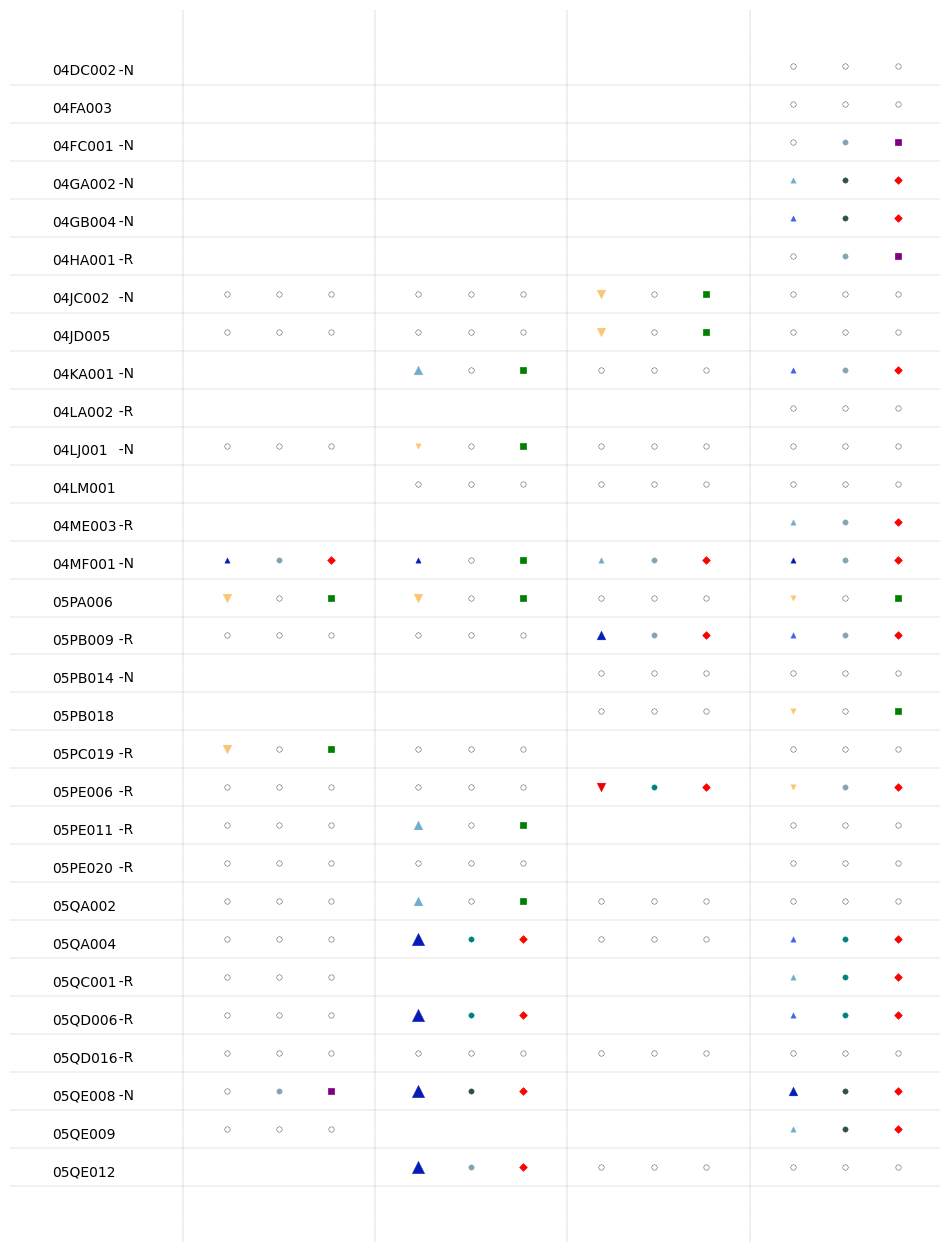

Loaded and trimmed image 'figure_1.png' as 'figure_1'
Loaded and trimmed image 'figure_2.png' as 'figure_2'
Loaded and trimmed image 'figure_3.png' as 'figure_3'
Loaded and trimmed image 'figure_4.png' as 'figure_4'
Loaded and trimmed image 'figure_5.png' as 'figure_5'
Loaded and trimmed image 'figure_6.png' as 'figure_6'
Loaded and trimmed image 'figure_7.png' as 'figure_7'


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\TIWARIDI\\OneDrive - Government of Ontario\\Documents\\WSCdata\\SOBR_FinalStations\\ResultTable\\Combined\\MAD.png'

In [9]:
file_paths = [
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2000\allSOBRplot\MKnP_MeanAnnualD.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1980_2010\allSOBRplot\MKnP_MeanAnnualD.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1990_2020\allSOBRplot\MKnP_MeanAnnualD.csv",
    r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\SOBR_plot\CNP1970_2020\allSOBRplot\MKnP_MeanAnnualD.csv"
]

result_dfs = [load_data(file_path) for file_path in file_paths]
result_df70, result_df80, result_df90, result_df2020 = result_dfs

# Assuming sobr_df and result_df70, result_df80, result_df90, result_df2020 are defined and populated DataFrames
stations_per_figure = 38
num_figures = -(-len(sobr_df) // stations_per_figure)
indm="MAF"
# Now you can use this function in your loop
for fig_num in range(num_figures):
    start_idx = fig_num * stations_per_figure
    end_idx = min((fig_num + 1) * stations_per_figure, len(sobr_df))
    subset_df = sobr_df.iloc[start_idx:end_idx]
    fig, ax = plt.subplots(figsize=(12, 16))

    plot_data(ax, subset_df, result_df70, result_df80, result_df90, result_df2020,fig_num,indm)

    ax.axis('off')
    save_directory = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\MAD'
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)
    save_path = os.path.join(save_directory, f'figure_{fig_num + 1}.png')
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
 
    plt.show() 
    
# Concatenating Images
folder_path = save_directory 
concatenated_image = st.concat_images(folder_path)

# concatenated_image.show()
save_path =  r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Combined\MAD.png"
concatenated_image.save(save_path)

#count percentage and toatl station number for each category
results_count=count_perc(result_dfs)
# Save the results to a CSV file
file_name = 'trend_analysis_results_table.csv'
# Save the DataFrame to a CSV file
results_count.to_csv(os.path.join(save_directory, file_name))

In [ ]:
stop

   just to stop code here

In [11]:
from PIL import Image
import os

path = r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Feb2025"

def crop():
    for root, _, files in os.walk(path):  # Recursively go through all subdirectories
        for item in files:
            fullpath = os.path.join(root, item)
            if os.path.isfile(fullpath):
                try:
                    im = Image.open(fullpath)
                    width, height = im.size  # Get original dimensions
                    f, e = os.path.splitext(fullpath)

                    # Crop 10 pixels from both left and right (adjust width)
                    left = 71
                    top = 0
                    right = width - 50
                    bottom = height - 190

                    imCrop = im.crop((left, top, right, bottom))  # Crop adjusted area
                    imCrop.save(f + '_C.png', "PNG", optimize=True)  # Save cropped image with "_C" suffix

                except Exception as e:
                    print(f"Error processing {fullpath}: {e}")  # Handle errors gracefully

crop()


In [21]:
import os

path = r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Feb2025"

for root, _, files in os.walk(path):  # Iterate through all subdirectories
    if any(file.lower().endswith(('.png', '.jpg', '.jpeg')) for file in files):  # Check if images exist
        concatenated_image = st.concat_images(root)  # Pass the folder path, not a list
        save_path = os.path.join(root, f"{os.path.basename(root)}.PNG")  # Save as subfolder name
        concatenated_image.save(save_path, "PNG", optimize=True)
        print(f"Saved: {save_path}")


Loaded and trimmed image 'figure_1_C.png' as 'figure_1'
Loaded and trimmed image 'figure_2_C.png' as 'figure_2'
Loaded and trimmed image 'figure_3_C.png' as 'figure_3'
Loaded and trimmed image 'figure_4_C.png' as 'figure_4'
Loaded and trimmed image 'figure_5_C.png' as 'figure_5'
Loaded and trimmed image 'figure_6_C.png' as 'figure_6'
Loaded and trimmed image 'figure_7_C.png' as 'figure_7'
Saved: C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Feb2025\3DMF\3DMF.PNG
Loaded and trimmed image 'figure_1.png' as 'figure_1'
Loaded and trimmed image 'figure_1_C.png' as 'figure_2'
Loaded and trimmed image 'figure_1_C_C.png' as 'figure_3'
Loaded and trimmed image 'figure_2.png' as 'figure_4'
Loaded and trimmed image 'figure_2_C.png' as 'figure_5'
Loaded and trimmed image 'figure_3.png' as 'figure_6'
Loaded and trimmed image 'figure_3_C.png' as 'figure_7'
Loaded and trimmed image 'figure_4.png' as 'figure_8'
Loaded and trimmed image 'figure_4_C.

In [26]:
from PIL import Image
import os

# Path to the folder containing the images
folder_path = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Feb2025\1combined'

# List of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# Sort the images if needed (optional step)
image_files.sort()

# Open all images
images = [Image.open(os.path.join(folder_path, image_file)) for image_file in image_files]

# Calculate the total width and the height of the concatenated image
total_width = sum(image.width for image in images)
max_height = max(image.height for image in images)

# Create a new image with the calculated dimensions
combined_image = Image.new('RGB', (total_width, max_height))

# Paste all images into the new image
current_x = 0
for image in images:
    combined_image.paste(image, (current_x, 0))
    current_x += image.width

# Save the combined image
combined_image.save(os.path.join(folder_path, 'combined.png'))

print("Image saved as 'combined.png'")


AttributeError: module 'PIL.Image' has no attribute 'concat'

In [28]:
from PIL import Image
import os

# Path to the folder containing the images
folder_path = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Feb2025\1combined'

# List of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.PNG')]

# Sort the images if needed (optional step)
image_files.sort()

# Open all images
images = [Image.open(os.path.join(folder_path, image_file)) for image_file in image_files]

# Calculate the total width and the height of the concatenated image
total_width = sum(image.width for image in images) - 50 * (len(images) - 1)  # Subtract 50 for each image except the first
max_height = max(image.height for image in images)

# Create a new image with the calculated dimensions
combined_image = Image.new('RGB', (total_width, max_height))

# Paste the first image at position (0, 0)
combined_image.paste(images[0], (0, 0))

# Paste the rest of the images, shifted by 50 pixels to the left
current_x = images[0].width - 50  # Start with the position after the first image with 50 pixel shift
for image in images[1:]:
    combined_image.paste(image, (current_x, 0))
    current_x += image.width - 50  # Shift each subsequent image by 50 pixels to the left

# Save the combined image
combined_image.save(os.path.join(folder_path, 'combined.png'))

print("Image saved as 'combined.png'")


Image saved as 'combined.png'


In [ ]:
from PIL import Image
import os

path = r"C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\MAD"
dirs = os.listdir(path)

def crop():
    for item in dirs:
        fullpath = os.path.join(path, item)         
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            width, height = im.size  # Get original dimensions
            f, e = os.path.splitext(fullpath)

            # Crop 10 pixels from both left and right (adjust width)
            left = 70
            top = 1
            right = width - 50
            bottom = height - 190

            imCrop = im.crop((left, top, right, bottom))  # Crop adjusted area
            imCrop.save(f + '_C.png', "PNG", optimize=True)  # PNG with optimization

crop()


In [ ]:
## TO CROP FROM FOLDER
from PIL import Image
import os.path, sys

path = "C:\\Users\\TIWARIDI\\OneDrive - Government of Ontario\\Documents\\WSCdata\\SOBR_FinalStations\\ResultTable\\MAD"
dirs = os.listdir(path)

def crop():
    for item in dirs:
        fullpath = os.path.join(path,item)         #corrected
        if os.path.isfile(fullpath):
            im = Image.open(fullpath)
            f, e = os.path.splitext(fullpath)
            imCrop = im.crop((30, 10, 2850, 3562)) #corrected
            imCrop.save(f + '_C.png', "png", quality=100)

crop()

In [ ]:
# Assuming result_df70, result_df80, result_df90, result_df2020 are your DataFrames
dfs = [result_df70, result_df80, result_df90, result_df2020]
# print(dfs)
# Concatenate all DataFrames
combined_df = pd.concat(dfs)

# Extract unique station names
unique_stations = combined_df['Station'].unique()

# Calculate the total number of unique stations
total_unique_stations = len(unique_stations)

# print("Unique Station Names:", unique_stations)
print("Total Number of Unique Stations:", total_unique_stations)

# Extract 'Station' column from each DataFrame
station_sets = [set(df['Station']) for df in dfs]

# Find intersection of all sets
common_stations = set.intersection(*station_sets)

# Calculate the number of common stations
num_common_stations = len(common_stations)

# print("Common Station Names:", common_stations)
print("Number of Common Stations:", num_common_stations)

In [ ]:
# print(sobr_df)
regulated_stations_df = sobr_df[sobr_df['Regulated'] == True]

# Extract the station names of regulated stations
regulated_station_names = regulated_stations_df['station'].tolist()

# Calculate the number of regulated stations
num_regulated_stations = len(regulated_station_names)

# print("Regulated Station Names:", regulated_station_names)
print("Number of Regulated Stations:", num_regulated_stations)



In [ ]:
dfs = [result_df70, result_df80, result_df90, result_df2020]
df_names = ['result_df70', 'result_df80', 'result_df90', 'result_df2020']

# Extract the station names of regulated stations
regulated_station_names = set(sobr_df[sobr_df['Regulated'] == True]['station'])

# Dictionary to hold the number of regulated stations in each DataFrame
regulated_counts = {}

for df, name in zip(dfs, df_names):
    # Count the number of regulated stations in the current DataFrame
    regulated_count = df['Station'].isin(regulated_station_names).sum()
    regulated_counts[name] = regulated_count

# Print the number of regulated stations in each DataFrame
for name, count in regulated_counts.items():
    print(f"Number of Regulated Stations in {name}: {count}")

In [ ]:
 Below code is just to produce csv for table
    do no need to run

In [ ]:
import pandas as pd

# File paths
file1 = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Station_LatLongArR_RHBN.csv'
file2 = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\SOBRstations1r.csv'
output_file = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Merged_Stations.csv'

# Load the CSV files
df1 = pd.read_csv(file1, sep='\t')  # Assuming tab-separated values
df2 = pd.read_csv(file2)

# Strip any leading or trailing whitespace from the column names
df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

# Merge the dataframes on the 'station' and 'Station' columns respectively
merged_df = pd.merge(df2, df1[['Station', 'RHBN']], left_on='station', right_on='Station', how='left')

# Drop the duplicate 'Station' column
merged_df = merged_df.drop(columns=['Station'])
print(merged_df)

# Save the resulting dataframe to a new CSV file
# merged_df.to_csv(output_file, index=False)

print(f'Merged CSV file has been created at: {output_file}')


In [ ]:
print(df2.columns)

In [35]:
from PIL import Image, ImageDraw, ImageFont
import os

# Path to the folder containing the images
folder_path = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Feb2025\1combined'

# List of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.PNG')]

# Check if the list is empty
if not image_files:
    raise ValueError("No PNG files found in the specified folder.")

# Sort the images if needed (optional step)
image_files.sort()

# Open all images
images = [Image.open(os.path.join(folder_path, image_file)) for image_file in image_files]

# Width and height of a single image
img_width, img_height = images[0].size

# Create a list of cropped images (remove 400 pixels from left of all except the first image)
cropped_images = [images[0]]  # Keep the first image as it is
for image in images[1:]:
    # Crop 400 pixels from the left (from position 400 to end)
    cropped_images.append(image.crop((400, 0, img_width, img_height)))

# Calculate the total width and height of the combined image
total_width = sum(img.width for img in cropped_images)
max_height = max(img.height for img in cropped_images)

# Create a new image with the calculated dimensions
combined_image = Image.new('RGB', (total_width, max_height))

# Paste the cropped images into the new image
current_x = 0
for image in cropped_images:
    combined_image.paste(image, (current_x, 0))
    current_x += image.width

# Add titles at the center of each image
draw = ImageDraw.Draw(combined_image)
font = ImageFont.load_default()  # You can replace this with a custom font if needed

current_x = 0
for idx, image in enumerate(cropped_images):
    title = os.path.splitext(image_files[idx])[0]  # Get filename without extension
    # Calculate the text size using textbbox
    text_bbox = draw.textbbox((0, 0), title, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    title_position = (current_x + (image.width - text_width) // 2, (img_height - text_height) // 2)
    draw.text(title_position, title, font=font, fill="white")  # Add text in white color
    current_x += image.width

# Save the combined image
combined_image.save(os.path.join(folder_path, 'combined.png'))

print("Image saved as 'combined.png'")


Image saved as 'combined.png'


In [38]:
from PIL import Image, ImageDraw, ImageFont
import os

# Path to the folder containing the images
folder_path = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Feb2025\1combined'

# List of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.endswith('.PNG')]

# Check if the list is empty
if not image_files:
    raise ValueError("No PNG files found in the specified folder.")

# Sort the images if needed (optional step)
image_files.sort()

# Open all images
images = [Image.open(os.path.join(folder_path, image_file)) for image_file in image_files]

# Width and height of a single image
img_width, img_height = images[0].size

# Create a list of cropped images (remove 400 pixels from left of all except the first image)
cropped_images = [images[0]]  # Keep the first image as it is
for image in images[1:]:
    # Crop 400 pixels from the left (from position 400 to end)
    cropped_images.append(image.crop((400, 0, img_width, img_height)))

# Calculate the total width and height of the combined image (height increased to fit text)
total_width = sum(img.width for img in cropped_images)
total_height = max(img.height for img in cropped_images) + 50  # Add space for text

# Create a new image with the calculated dimensions
combined_image = Image.new('RGB', (total_width, total_height), (255, 255, 255))  # White background

# Paste the cropped images into the new image
current_x = 0
for image in cropped_images:
    combined_image.paste(image, (current_x, 50))  # Paste images below the text
    current_x += image.width

# Add titles above each image
draw = ImageDraw.Draw(combined_image)
try:
    font = ImageFont.truetype('arial.ttf', size=100)  # Custom font with larger size
except IOError:
    font = ImageFont.load_default()  # Fallback to default font if Arial is not available

current_x = 0
for idx, image in enumerate(cropped_images):
    title = os.path.splitext(image_files[idx])[0]  # Get filename without extension
    # Calculate the size of the text
    text_bbox = draw.textbbox((0, 0), title, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    # Position text in the center above each image
    title_position = (current_x + (image.width - text_width) // 2, 10)  # 10 pixels padding from top
    draw.text(title_position, title, font=font, fill="black")  # Black text for visibility
    current_x += image.width

# Save the combined image
combined_image.save(os.path.join(folder_path, 'combined.png'))

print("Image saved as 'combined.png'")


Image saved as 'combined.png'


In [45]:
from PIL import Image, ImageDraw, ImageFont
import os

# Path to the folder containing the images
folder_path = r'C:\Users\TIWARIDI\OneDrive - Government of Ontario\Documents\WSCdata\SOBR_FinalStations\ResultTable\Feb2025\1combined'

# List of image files in the folder
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]

# Check if the list is empty
if not image_files:
    raise ValueError("No PNG files found in the specified folder.")

# Sort the images if needed (optional step)
image_files.sort()

# Open all images
images = [Image.open(os.path.join(folder_path, image_file)) for image_file in image_files]

# Width and height of a single image
img_width, img_height = images[0].size

# Create a list of cropped images (remove 400 pixels from left of all except the first image)
cropped_images = [images[0]]  # Keep the first image as it is
for image in images[1:]:
    # Crop 400 pixels from the left (from position 400 to end)
    cropped_images.append(image.crop((480, 0, img_width, img_height)))

# Calculate the total width and height of the combined image (height increased to fit text)
total_width = sum(img.width for img in cropped_images) + len(cropped_images) - 1  # Adding space for vertical lines
total_height = max(img.height for img in cropped_images) + 50  # Add space for text

# Create a new image with the calculated dimensions
combined_image = Image.new('RGB', (total_width, total_height), (255, 255, 255))  # White background

# Paste the cropped images into the new image and add lines between them
current_x = 0
for idx, image in enumerate(cropped_images):
    combined_image.paste(image, (current_x, 50))  # Paste images below the text
    current_x += image.width
    if idx < len(cropped_images) - 1:  # Draw line between images (not after the last one)
        draw = ImageDraw.Draw(combined_image)
        draw.line([(current_x, 50), (current_x, total_height)], fill="black", width=15)  # Black line

# Add titles above each image
draw = ImageDraw.Draw(combined_image)
try:
    font = ImageFont.truetype('arial.ttf', size=60)  # Custom font with larger size
except IOError:
    font = ImageFont.load_default()  # Fallback to default font if Arial is not available

current_x = 0
for idx, image in enumerate(cropped_images):
    title = os.path.splitext(image_files[idx])[0]  # Get filename without extension
    # Calculate the size of the text
    text_bbox = draw.textbbox((0, 0), title, font=font)
    text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]
    
    # Position text in the center above each image
    title_position = (current_x + (image.width - text_width) // 2, 10)  # 10 pixels padding from top
    draw.text(title_position, title, font=font, fill="black")  # Black text for visibility
    current_x += image.width
    if idx < len(cropped_images) - 1:  # Draw line after each title (except the last one)
        current_x += 10  # Space for the line

# Save the combined image
combined_image.save(os.path.join(folder_path, 'combined.png'))

print("Image saved as 'combined.png'")


Image saved as 'combined.png'
